In [104]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Exclusions and Outliers
-- 3 subject sub-5f706a963b6ac2627a4bb3b5 & sub-611c31c77df20ecc6881cc44 reported 0 variance distributions

In [105]:
sub_df=[]
subs=os.listdir('bids')
for sub in subs:
    #print(sub)
    if sub not in['sub-5f706a963b6ac2627a4bb3b5','sub-611c31c77df20ecc6881cc44',
                 'sub-5d8aa95dd06260000179442b']:#reported 0 variance distributions
        mem=pd.read_csv('bids/%s/%s_mem-report.tsv'%(sub,sub),sep='\t')
        mem['value']=pd.to_numeric(mem['value'])
        
        
        mem.loc[mem['value'] < 0, 'value'] = 0
        
        mem=pd.DataFrame(mem.values.repeat(mem.value, axis=0), columns=mem.columns)
        mem.percent=pd.to_numeric(mem.percent)
        mem['value']=pd.to_numeric(mem['value'])
        mem['order']=pd.to_numeric(mem['order'])
        mem=mem[['dist','percent','value','order']]
        O_df=mem.groupby('dist').mean().reset_index()
        order_var=O_df[O_df['dist']=='wide']['order'].values-O_df[O_df['dist']=='narrow']['order'].values
        if len(mem.groupby('dist').mean())>2:
            mem_df=pd.DataFrame()
            mem_df['dist']=['narrow','skew','wide']
            mem_df['narrow_first']=order_var[0]
            mem_df['means']=mem.groupby('dist').mean()['percent'].values
            mem_df['stds']=mem.groupby('dist').std()['percent'].values
            mem_df['skew']=mem.groupby('dist').skew()['percent'].values
            mem_df['sub']=(sub)
            sub_df.append(mem_df)
        else:
            #print(sub)
            pass
sub_df=pd.concat(sub_df)
sub_df=sub_df.reset_index()
sub_df.head()

index    dist  narrow_first      means       stds      skew  \
0      0  narrow          -1.0  50.000000  33.166248  0.000000   
1      1    skew          -1.0  71.764706  14.677915 -0.209272   
2      2    wide          -1.0  48.000000  36.292463  0.123724   
3      0  narrow          -1.0  59.166667  19.286516  0.505403   
4      1    skew          -1.0  47.058824  27.102746 -0.458493   

                            sub  
0  sub-5858b2ca83a02d0001e38fd2  
1  sub-5858b2ca83a02d0001e38fd2  
2  sub-5858b2ca83a02d0001e38fd2  
3  sub-5c7e764fa7432a00169e1499  
4  sub-5c7e764fa7432a00169e1499

In [106]:
import statsmodels.api as sm
row=[]
exclude=[]
for sub in sub_df['sub'].unique():
    df=pd.read_csv('bids/%s/%s_task-risk_run-1_events.tsv'%(sub,sub),
                   sep='\t')
    df['side'] = df['side'].apply(lambda x: x.replace('"', ''))
    df['side'] = df['side'].apply(lambda x: x.replace('[', ''))
    df['side'] = df['side'].apply(lambda x: x.replace(']', ''))
    df['choose_risk']=df['side']==df['select']
    if any(df[df['choose_risk']==False]['p1']>99):
        exclude.append(sub)
    elif any(df[df['choose_risk']==True]['p1']<0.02):
        exclude.append(sub)
    #else:
    #sns.lmplot(x='p1',y='choose_risk',logistic=True,data=df)
    Xtrain=df[['p1']]
    ytrain=df[['choose_risk']]
    log_reg = sm.OLS(ytrain, Xtrain).fit(disp=False)
    row.append([sub,log_reg.params['p1'],log_reg.pvalues['p1']])
    if log_reg.params['p1']<0:
        print(sub,log_reg.params['p1'],log_reg.pvalues['p1'])
        sns.lmplot(x='p1',y='choose_risk',data=df,logistic=False)
        plt.show()
Psens_df=pd.DataFrame(columns=['sub','coef','p'],data=row)

/home/strange/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


In [107]:
print("Out of %s participants an additional %s were excluded do to choice checks"%(len(
    sub_df['sub'].unique()),len(exclude)))
print("This leaves us with a total of %s"%(len(
    sub_df['sub'].unique())-len(exclude)))

Out of 295 participants an additional 40 were excluded do to choice checks
This leaves us with a total of 255


## Manipulation Check
Notes:
- Some negative frequencies were reported were making them 0
- Some reports were not filled for all distributions


In [108]:
sub_df=sub_df[~sub_df['sub'].isin(exclude)]
len(sub_df['sub'].unique())

255

Testing if wide distributions were reported with greater deviationthan narrow distributions 
 t: -14.96941708917463 p: 1.1643577765450404e-35


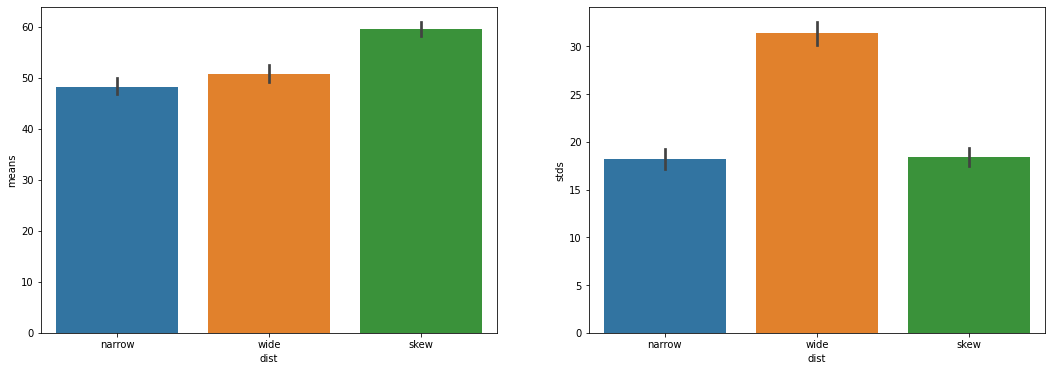

In [94]:
from scipy.stats import ttest_rel
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(x='dist',y='means',data=sub_df, ax=ax[0],order=['narrow','wide','skew'])
sns.barplot(x='dist',y='stds',data=sub_df, ax=ax[1],order=['narrow','wide','skew'])
#sns.barplot(x='dist',y='skew',data=sub_df, ax=ax[2])
t,p=ttest_rel(sub_df[sub_df['dist']=='narrow']['stds'],
              sub_df[sub_df['dist']=='wide']['stds'])

print("Testing if wide distributions were reported with greater deviation"+
      "than narrow distributions \n t: %s p: %s"
     %(t,p))

plt.show()

1= wide after narrow
-1= wide before narrow

Test for order effects on wide t: -2.3824041515767886 p: 0.018822863820723446 
Test for order effects on narrow t: 2.2254339581031313 p: 0.028165531285454525 


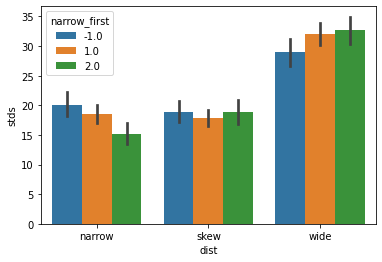

In [22]:
from scipy.stats import ttest_ind
plt_df=sub_df
sns.barplot(x='dist',y='stds',data=sub_df,hue='narrow_first')
group1 = plt_df[(plt_df['narrow_first']==-1)&(plt_df['dist']=='wide')]
group2 = plt_df[(plt_df['narrow_first']!=-1)&(plt_df['dist']=='wide')]
t,p=ttest_ind(group1['stds'], group2['stds'],equal_var=False)
print("Test for order effects on wide t: %s p: %s "%(t,p))
group1 = plt_df[(plt_df['narrow_first']==-1)&(plt_df['dist']=='narrow')]
group2 = plt_df[~(plt_df['narrow_first']==-1)&(plt_df['dist']=='narrow')]
t,p=ttest_ind(group1['stds'], group2['stds'],equal_var=False)
print("Test for order effects on narrow t: %s p: %s "%(t,p))


# Hypothesis 1A:
- During the ambiguous decision task, participants will be more averse to ambiguous lotteries which were associated with a high compared to low variance in the probabilities, learned during a prior risky decision task. 
- Choice ~ Probability + distri|bution [‘wide’, ‘narrow’] + (1|sub) 

In [23]:
amb_df=[]
for sub in sub_df['sub'].unique():
        amb=pd.read_csv('bids/%s/%s_task-amb_run-1_events.tsv'%(sub,sub),sep='\t')
        amb['sub']=sub
        amb['order']=sub_df[sub_df['sub']==sub]['narrow_first']
        amb_df.append(amb)
amb_df=pd.concat(amb_df)
print("no NA values for choice ",amb_df['choice'].unique())
amb_df['choose_risk']=amb_df['choice']=='risk'
print("no NA values for Amb ",amb_df['Amb'].unique())
amb_df['full_A']=amb_df['Amb']=='[0,1]'
print("no NA values for dist ",amb_df['dist'].unique())
amb_df['wide_dist']=amb_df['dist']=='wide'


amb_df.head()


no NA values for choice  ['risk' 'Ambiguous']
no NA values for Amb  ['[0.25,0.75]' '[0,1]']
no NA values for dist  ['wide' 'narrow' 'skew']


Blocktype  tnum      rt color   per          Amb     choice  dist   side  \
0  Ambiguity   0.0  1666.0  blue  0.50  [0.25,0.75]       risk  wide  right   
1  Ambiguity   1.0  2371.0  blue  0.41  [0.25,0.75]  Ambiguous  wide  right   
2  Ambiguity   2.0  1480.0  blue  0.46  [0.25,0.75]       risk  wide   left   
3  Ambiguity   3.0  1457.0  blue  0.42  [0.25,0.75]  Ambiguous  wide  right   
4  Ambiguity   4.0  1914.0  blue  0.43  [0.25,0.75]  Ambiguous  wide  right   

  response                           sub  choose_risk  full_A  wide_dist  
0        j  sub-5858b2ca83a02d0001e38fd2         True   False       True  
1        f  sub-5858b2ca83a02d0001e38fd2        False   False       True  
2        f  sub-5858b2ca83a02d0001e38fd2         True   False       True  
3        f  sub-5858b2ca83a02d0001e38fd2        False   False       True  
4        f  sub-5858b2ca83a02d0001e38fd2        False   False       True

In [78]:
from pymer4.models import Lmer
model_df=amb_df[amb_df['full_A']==True]

model = Lmer("choose_risk  ~ per*wide_dist  + (per|sub)",
             data=model_df, family = 'binomial')

display(model.fit(factors={"full_A": ["True", "False"],"wide_dist":["True","False"]}))


Formula: choose_risk~per*wide_dist+(per|sub)

Family: binomial	 Inference: parametric

Number of observations: 10150	 Groups: {'sub': 227.0}

Log-likelihood: -6274.623 	 AIC: 12563.247

Random effects:

            Name      Var     Std
sub  (Intercept)   47.405   6.885
sub          per  184.123  13.569

             IV1  IV2   Corr
sub  (Intercept)  per -0.979

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE            OR    OR_2.5_ci  \
(Intercept)       -8.230  -9.316   -7.143  0.554  0.000000e+00        0.000   
per               16.720  14.548   18.893  1.109  1.826199e+07  2079254.548   
wide_dist1         0.104  -0.238    0.447  0.175  1.110000e+00        0.788   
per:wide_dist1    -0.385  -1.079    0.308  0.354  6.800000e-01        0.340   

                  OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  \
(Intercept)     1.000000e-03  0.000        0.000         0.001 -14.846  0.000   
per             1.603941e+08  1.000        1.000         1.000  15.082  0.000   
wide_dist1      1.564000e+00  0.526        0.441         0.610   0.598  0.550   
per:wide_dist1  1.361000e+00  0.405        0.254         0.576  -1.089  0.276   

                Sig  
(Intercept)     ***  
per             ***  
wide_dist1           
per:wide_dist1

In [71]:
from scipy.stats import chisquare
model_df['full_A1']=model_df['full_A']
amb_df['wide_dist1']=model_df['wide_dist']
amb_df['per:full_A1']=model_df['per']*model_df['full_A1']
amb_df['per:wide_dist1']=amb_df['per']*model_df['wide_dist1']
amb_df['full_A1:wide_dist1']=amb_df['full_A1']*model_df['wide_dist1']
amb_df['per:full_A1:wide_dist1']=amb_df['per']*model_df['wide_dist1']*amb_df['full_A1']
y_pred=(model.predict(amb_df)>0.5)
y_true=amb_df['choose_risk'].values
chisquare([np.sum([a == p for a,p in zip(y_pred,y_true)]),
           np.sum([a != p for a,p in zip(y_pred,y_true)])])

Power_divergenceResult(statistic=1737.567125984252, pvalue=0.0)

In [74]:
y_pred=model.predict(amb_df)
y_true=amb_df['choose_risk'].values

def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)
efron_rsquare(y_true,y_pred)

-0.11102344941998332

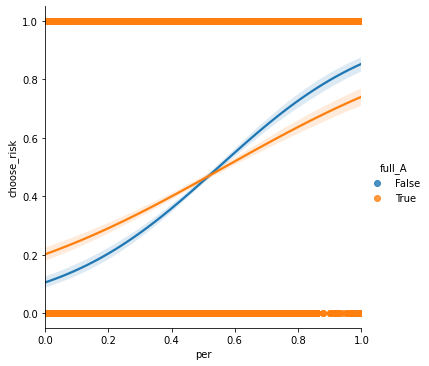

In [76]:
sns.lmplot(x='per',y='choose_risk',hue='full_A',data=amb_df,logistic=True)

# Hypothesis 1B:
- During the ambiguous decision task, participants will be more averse to high variance lotteries if, during the risky decision task they learned about the high variance distribution after the low variance distribution. 
- Choice ~ Probability + Order [ wide before or after narrow] 

In [89]:
amb_df=[]
for sub in sub_df['sub'].unique():
        amb=pd.read_csv('bids/%s/%s_task-amb_run-1_events.tsv'%(sub,sub),sep='\t')
        amb['sub']=sub
        amb['order']=sub_df[sub_df['sub']==sub]['narrow_first'].values[0]
        #print(amb['order'])
        amb_df.append(amb)
amb_df=pd.concat(amb_df)
print("no NA values for choice ",amb_df['choice'].unique())
amb_df['choose_risk']=amb_df['choice']=='risk'
print("no NA values for Amb ",amb_df['Amb'].unique())
amb_df['full_A']=amb_df['Amb']=='[0,1]'
print("no NA values for dist ",amb_df['dist'].unique())
amb_df['wide_dist']=amb_df['dist']=='wide'
print("no NA values for order ",amb_df['order'].unique())

amb_df.head()


no NA values for choice  ['risk' 'Ambiguous']
no NA values for Amb  ['[0.25,0.75]' '[0,1]']
no NA values for dist  ['wide' 'narrow' 'skew']
no NA values for order  [-1.  2.  1.]


Blocktype  tnum      rt color   per          Amb     choice  dist   side  \
0  Ambiguity   0.0  1666.0  blue  0.50  [0.25,0.75]       risk  wide  right   
1  Ambiguity   1.0  2371.0  blue  0.41  [0.25,0.75]  Ambiguous  wide  right   
2  Ambiguity   2.0  1480.0  blue  0.46  [0.25,0.75]       risk  wide   left   
3  Ambiguity   3.0  1457.0  blue  0.42  [0.25,0.75]  Ambiguous  wide  right   
4  Ambiguity   4.0  1914.0  blue  0.43  [0.25,0.75]  Ambiguous  wide  right   

  response                           sub  order  choose_risk  full_A  \
0        j  sub-5858b2ca83a02d0001e38fd2   -1.0         True   False   
1        f  sub-5858b2ca83a02d0001e38fd2   -1.0        False   False   
2        f  sub-5858b2ca83a02d0001e38fd2   -1.0         True   False   
3        f  sub-5858b2ca83a02d0001e38fd2   -1.0        False   False   
4        f  sub-5858b2ca83a02d0001e38fd2   -1.0        False   False   

   wide_dist  
0       True  
1       True  
2       True  
3       True  
4       True

In [90]:
from pymer4.models import Lmer
model_df=amb_df[(amb_df['full_A']==True)&(amb_df['wide_dist']==True)]

model = Lmer("choose_risk  ~ per*order  + (per|sub)",
             data=model_df, family = 'binomial')

display(model.fit())


From cffi callback <function _processevents at 0x7f9513edcc20>:
Traceback (most recent call last):
  File "/home/strange/anaconda3/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


Formula: choose_risk~per*order+(per|sub)

Family: binomial	 Inference: parametric

Number of observations: 20320	 Groups: {'sub': 227.0}

Log-likelihood: -12261.375 	 AIC: 24536.749

Random effects:

            Name      Var     Std
sub  (Intercept)   67.087   8.191
sub          per  263.633  16.237

             IV1  IV2   Corr
sub  (Intercept)  per -0.988

Fixed effects:



Estimate  2.5_ci  97.5_ci     SE            OR    OR_2.5_ci  \
(Intercept)    -8.528  -9.874   -7.182  0.687  0.000000e+00        0.000   
per            16.817  14.145   19.488  1.363  2.010600e+07  1389924.189   
order           0.018  -0.984    1.020  0.511  1.018000e+00        0.374   
per:order       0.190  -1.800    2.180  1.015  1.209000e+00        0.165   

               OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  \
(Intercept)  1.000000e-03  0.000        0.000         0.001 -12.420  0.000   
per          2.908441e+08  1.000        1.000         1.000  12.336  0.000   
order        2.774000e+00  0.505        0.272         0.735   0.035  0.972   
per:order    8.847000e+00  0.547        0.142         0.898   0.187  0.851   

             Sig  
(Intercept)  ***  
per          ***  
order             
per:order

In [71]:
from scipy.stats import chisquare
amb_df['full_A1']=amb_df['full_A']
amb_df['wide_dist1']=amb_df['wide_dist']
amb_df['per:full_A1']=amb_df['per']*amb_df['full_A1']
amb_df['per:wide_dist1']=amb_df['per']*amb_df['wide_dist1']
amb_df['full_A1:wide_dist1']=amb_df['full_A1']*amb_df['wide_dist1']
amb_df['per:full_A1:wide_dist1']=amb_df['per']*amb_df['wide_dist1']*amb_df['full_A1']
y_pred=(model.predict(amb_df)>0.5)
y_true=amb_df['choose_risk'].values
chisquare([np.sum([a == p for a,p in zip(y_pred,y_true)]),
           np.sum([a != p for a,p in zip(y_pred,y_true)])])

Power_divergenceResult(statistic=1737.567125984252, pvalue=0.0)

In [74]:
y_pred=model.predict(amb_df)
y_true=amb_df['choose_risk'].values

def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)
efron_rsquare(y_true,y_pred)

-0.11102344941998332

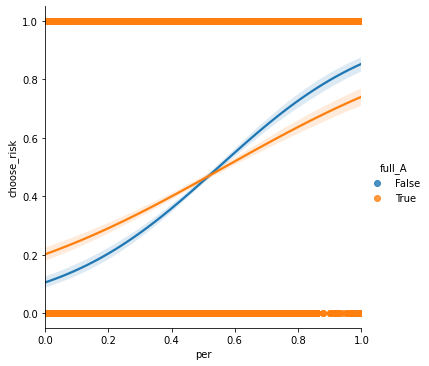

In [76]:
sns.lmplot(x='per',y='choose_risk',hue='full_A',data=amb_df,logistic=True)

In [11]:
from pingouin import mediation_analysis
mediation_analysis(data=df, x='X', m='M', y='Y', alpha=0.05,

                   seed=42)

NameError: name 'mediation_analysis' is not defined

In [99]:
plt_df

Blocktype  tnum      rt  color   per          Amb     choice  dist   side  \
0   Ambiguity   0.0  1666.0   blue  0.50  [0.25,0.75]       risk  wide  right   
1   Ambiguity   1.0  2371.0   blue  0.41  [0.25,0.75]  Ambiguous  wide  right   
2   Ambiguity   2.0  1480.0   blue  0.46  [0.25,0.75]       risk  wide   left   
3   Ambiguity   3.0  1457.0   blue  0.42  [0.25,0.75]  Ambiguous  wide  right   
4   Ambiguity   4.0  1914.0   blue  0.43  [0.25,0.75]  Ambiguous  wide  right   
..        ...   ...     ...    ...   ...          ...        ...   ...    ...   
85  Ambiguity  85.0   345.0  green  0.54        [0,1]  Ambiguous  skew   left   
86  Ambiguity  86.0   943.0  green  0.54        [0,1]  Ambiguous  skew  right   
87  Ambiguity  87.0   732.0  green  0.60        [0,1]       risk  skew  right   
88  Ambiguity  88.0   843.0  green  0.56        [0,1]  Ambiguous  skew  right   
89  Ambiguity  89.0   937.0  green  0.56        [0,1]       risk  skew   left   

   response                           sub  order  choose_risk  full_A  \
0         j  sub-5858b2ca83a02d0001e38fd2   -1.0         True   False   
1         f  sub-5858b2ca83a02d0001e38fd2   -1.0        False   False   
2         f  sub-5858b2ca83a02d0001e38fd2   -1.0         True   False   
3         f  sub-5858b2ca83a02d0001e38fd2   -1.0        False   False   
4         f  sub-5858b2ca83a02d0001e38fd2   -1.0        False   False   
..      ...                           ...    ...          ...     ...   
85        j  sub-5858b2ca83a02d0001e38fd2   -1.0        False    True   
86        f  sub-5858b2ca83a02d0001e38fd2   -1.0        False    True   
87        j  sub-5858b2ca83a02d0001e38fd2   -1.0         True    True   
88        f  sub-5858b2ca83a02d0001e38fd2   -1.0        False    True   
89        f  sub-5858b2ca83a02d0001e38fd2   -1.0         True    True   

    wide_dist  
0        True  
1        True  
2        True  
3        True  
4        True  
..        ...  
85      False  
86      False  
87      False  
88      False  
89      False  

[90 rows x 15 columns]

sub-5858b2ca83a02d0001e38fd2


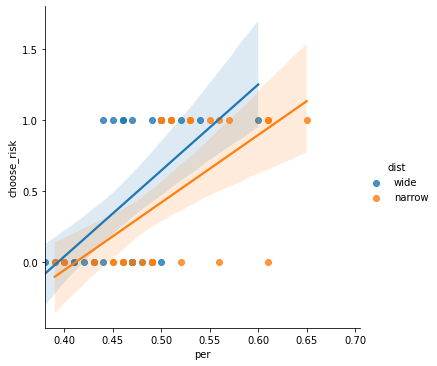

sub-5c7e764fa7432a00169e1499


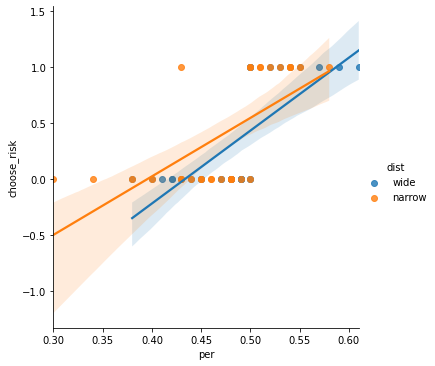

sub-5fb16308dc5973607fa3041c


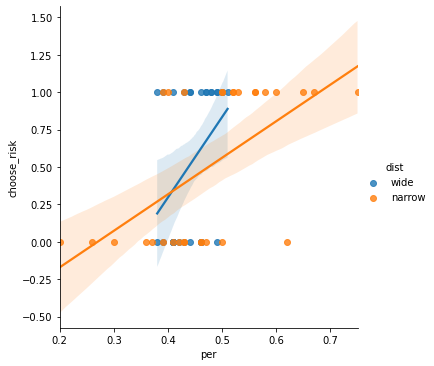

sub-60e5eceb989f38c746723024


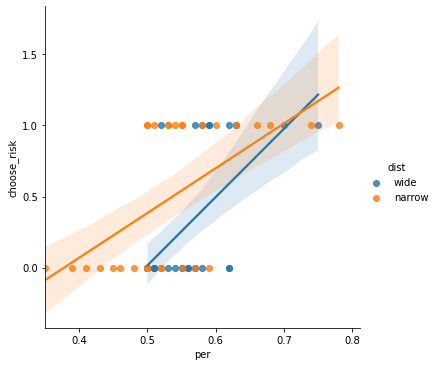

sub-5dcc27974b54778b69e62ec5


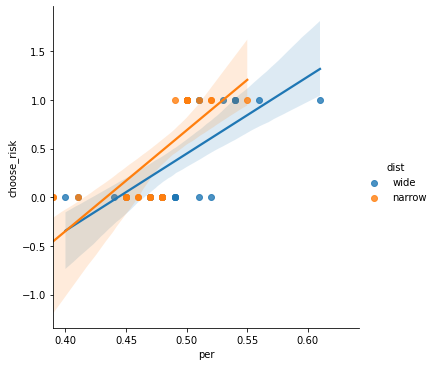

sub-5c5cd939a1ff0d0001176b6e


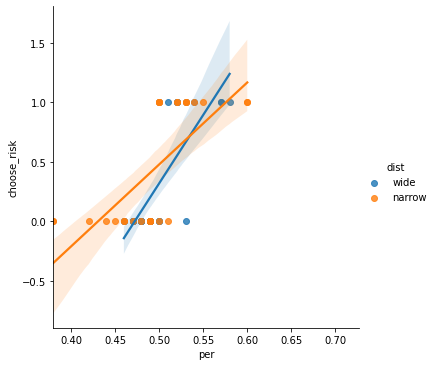

sub-5a0efb83ab721b0001ef8509


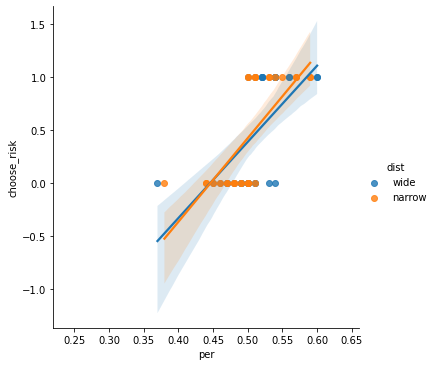

sub-5e3360a4499e7932901951cb


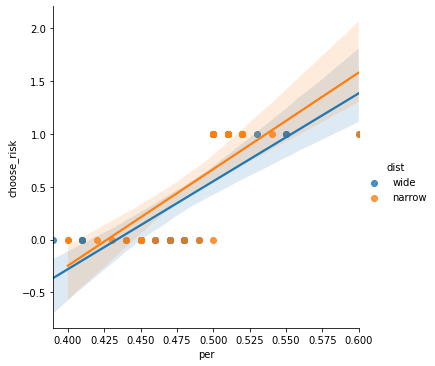

sub-5e7146ee69a3f1061774803b


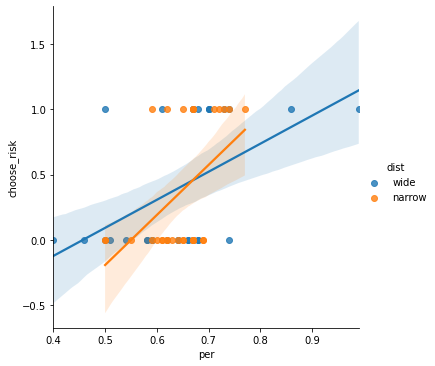

sub-5dd35813794e103649612ffd


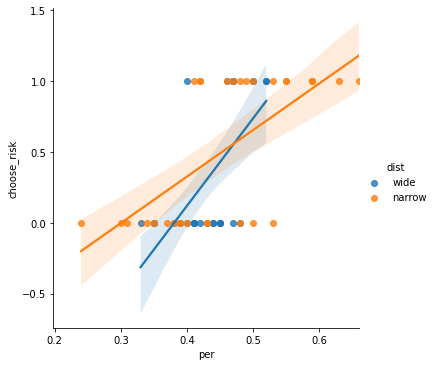

sub-639e0331bc3cc615f5a3dd89


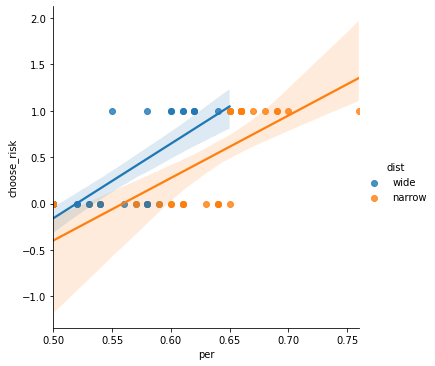

sub-5e2b74daae56b71b9d24d89b


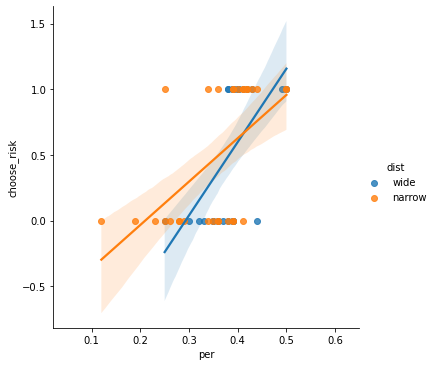

sub-5f8ac3760d1aa703601582ef


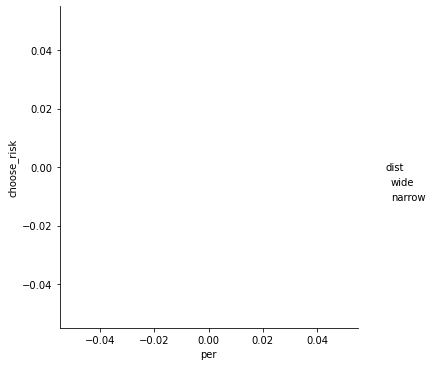

sub-59c86f966a287600011c393e


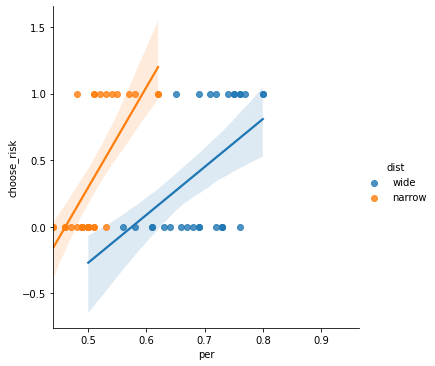

sub-5c872cded9fe700001024123


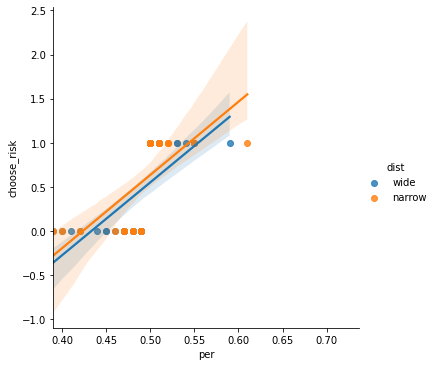

sub-62d3864d8929960c0bd35335


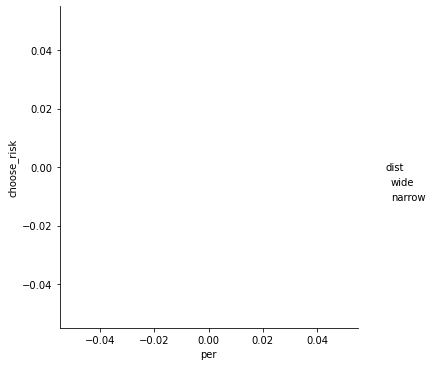

sub-5f1e20e5499c5d7c27d24658


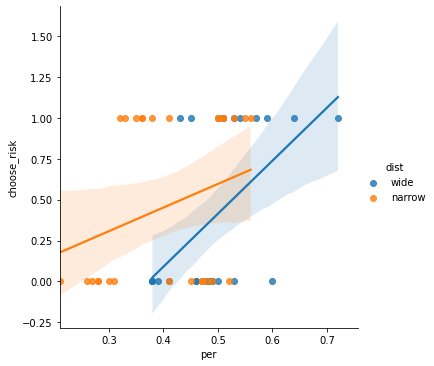

sub-56ad40ce5ea7aa000cbe1947


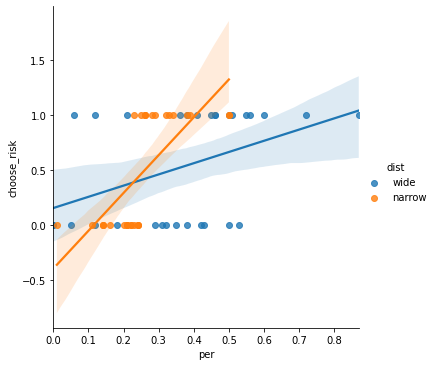

sub-5e16c978783225c8108ef055


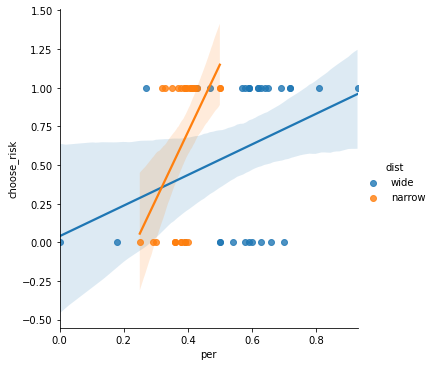

sub-5f852dee17ab6c2136ac62e4


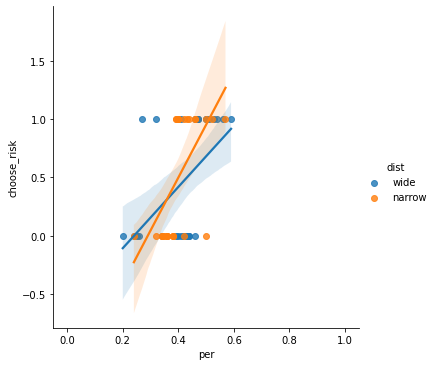

sub-5de9938dad51830cad0ea9f9


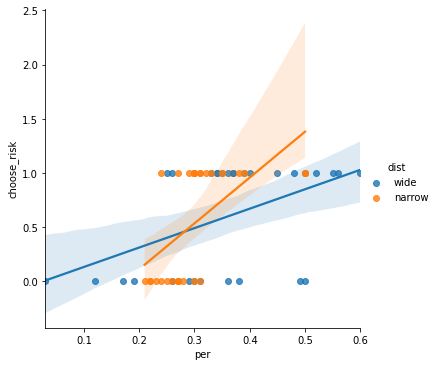

sub-6159d4026fd4e22c9f1179c1


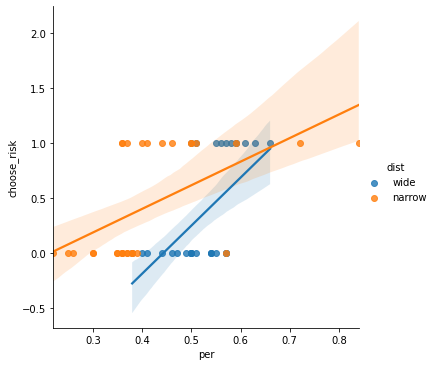

sub-63d83ae132a2e28694dd8431


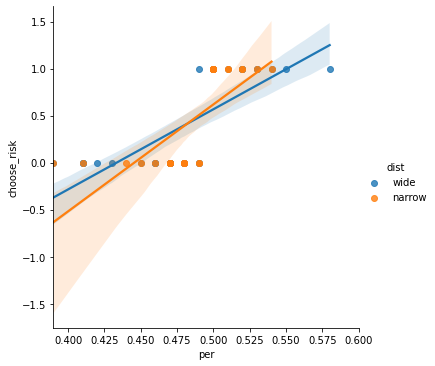

sub-5ed559e5afbd830e2117ed55


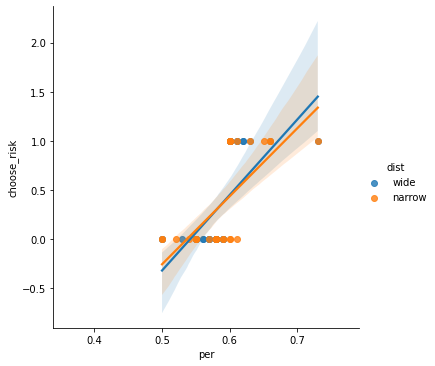

sub-5c4d5328889752000156a11d


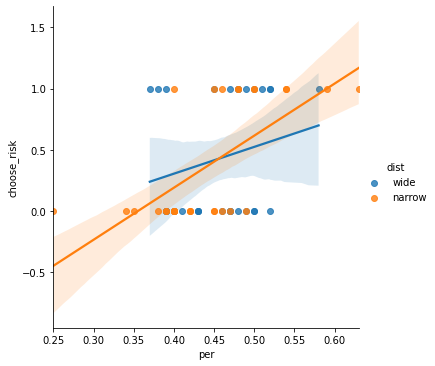

sub-64467092479723cb7906e371


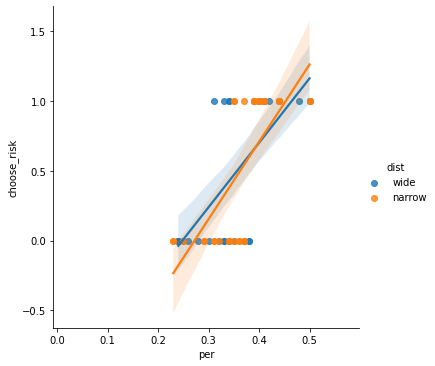

sub-5ecff126aa853e08a8f95e5b


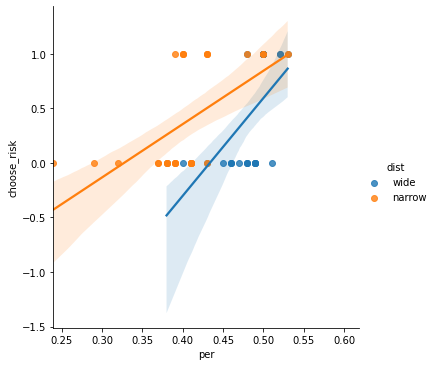

sub-5f5eb22e58c9fb7782a6e90c


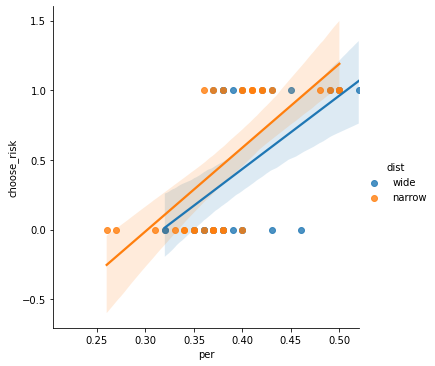

sub-5cb34fdb9a26a300017302d8


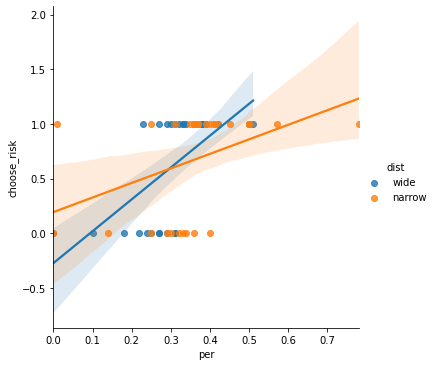

sub-5f036ad6524fe7281a4ad892


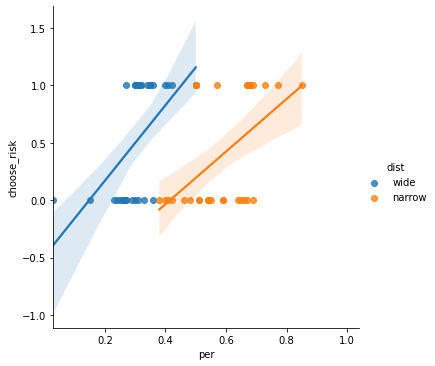

sub-60d38bc77bf91667dce30e64


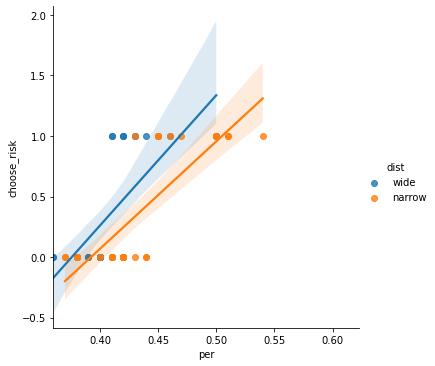

sub-614e0c53139a2a838010794c


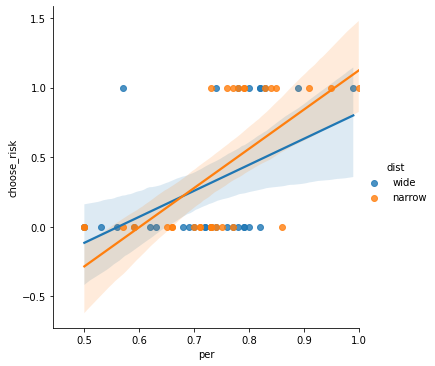

sub-5b060d9e68eff50001d1a2c1


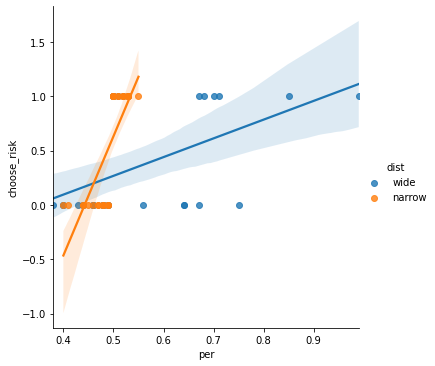

sub-5bd6656a669ee1000145304a


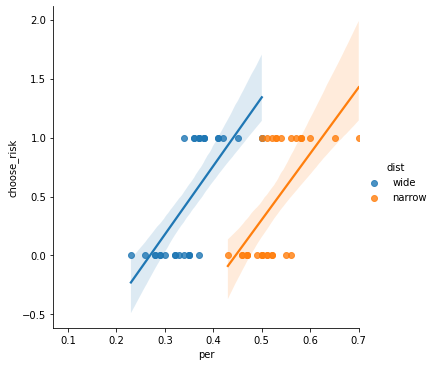

sub-64551d250ef342507eb0edf9


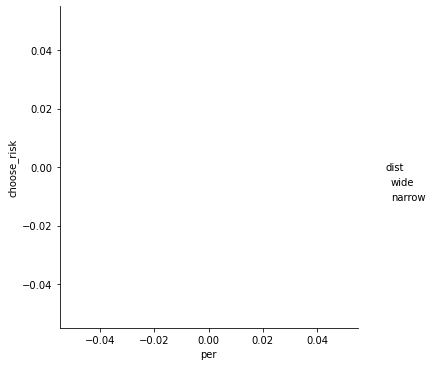

sub-62ff8aa20b2d8c0e359e9799


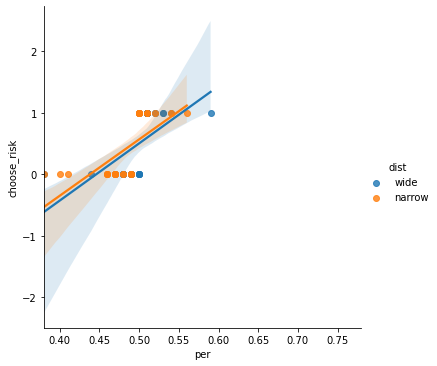

sub-5daa9e16546237001681d0f1


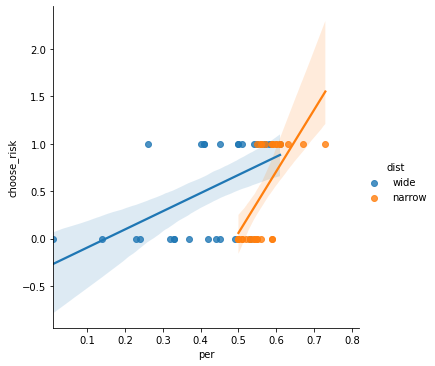

sub-607eafaf008af56a5a3ba462


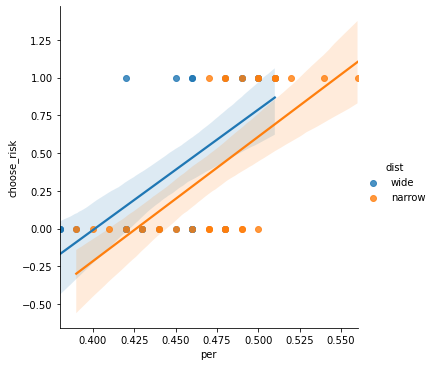

sub-55c82012fdf99b02adc2a36e


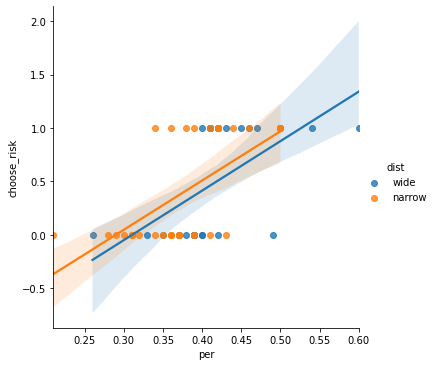

sub-6109dc13ff3d4be24267e74d


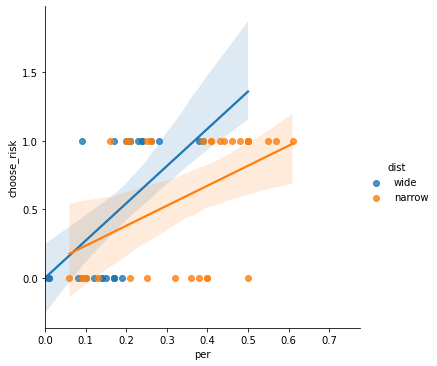

sub-600319e3a3b1a337cab57a3e


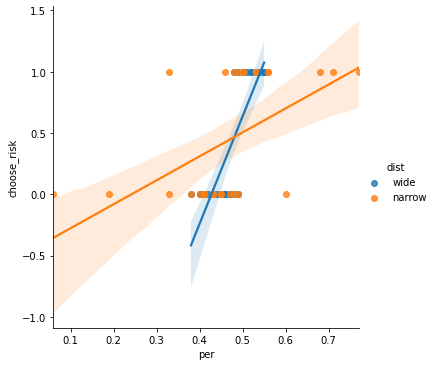

sub-5c21923289f03500017369fd


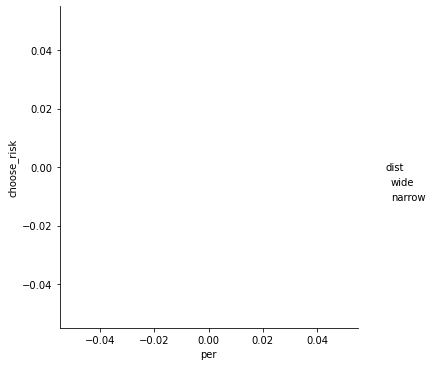

sub-55c4fc3dfdf99b559867a416


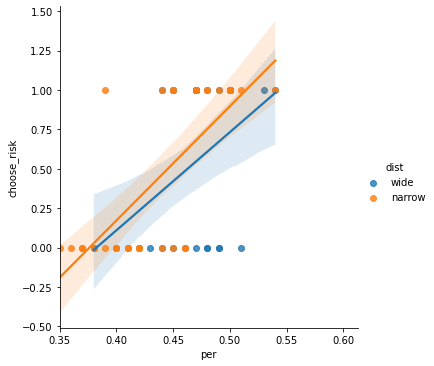

sub-61031099119779bccc1a37bb


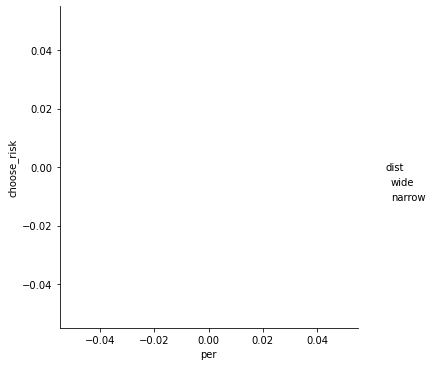

sub-6081ca47eeed1bb51c1d7f7b


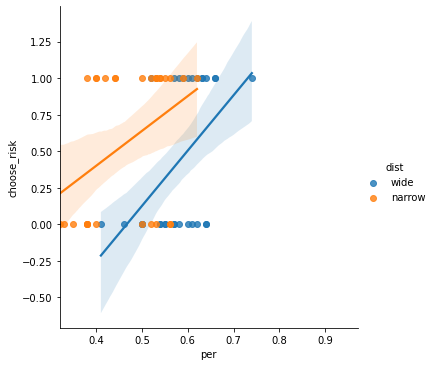

sub-60d7558fd3a01169626ae963


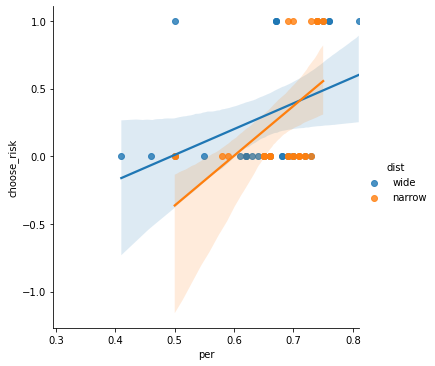

sub-5c79608452e62f00169b1fe6


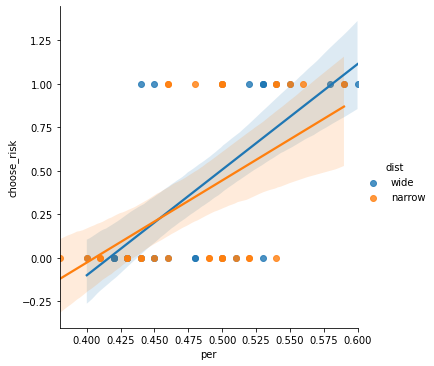

sub-5f1fec6a43c2810190bb090c


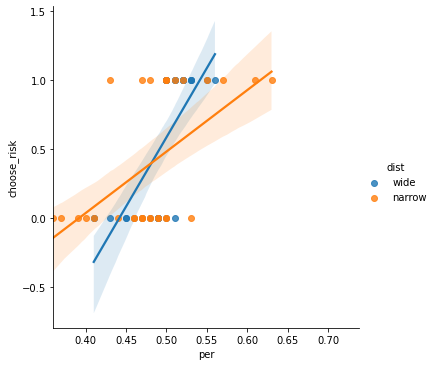

sub-5e647c63c9f0751fc59aba6f


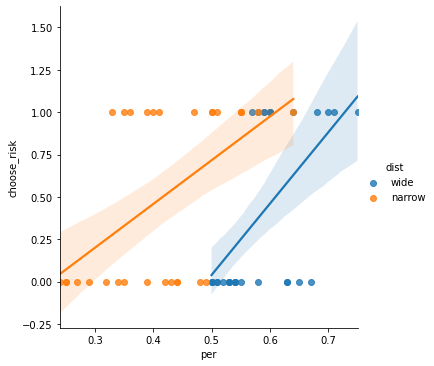

sub-62f269f2a7751126ffb96a4c


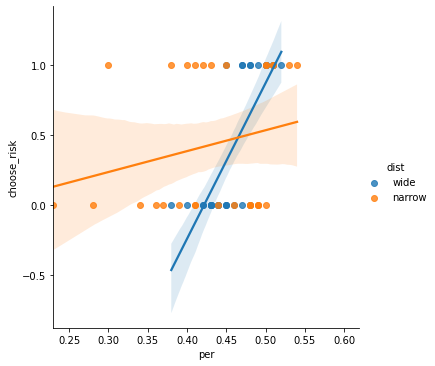

sub-5c41fb6f848dbb000157e2e5


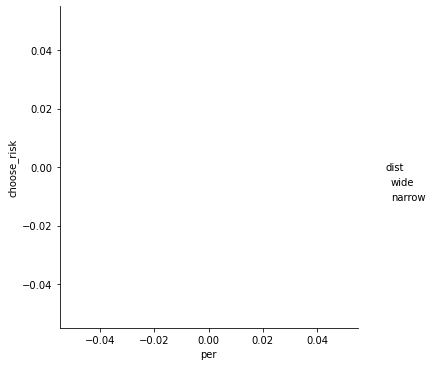

sub-63d2797ee24c80630f3b67e1


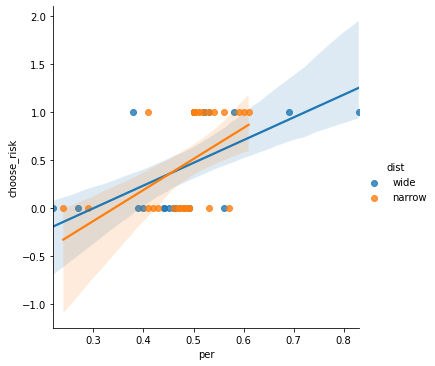

sub-54a7516dfdf99b7cd759d22b


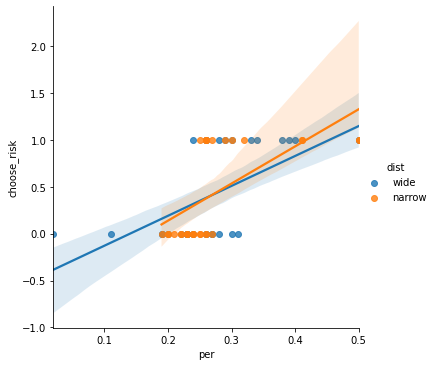

sub-5de5538f8fde1c4dbc951498


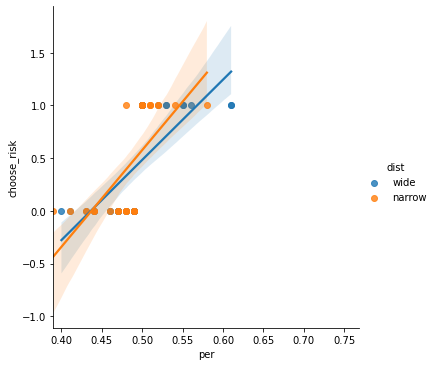

sub-5de7d12c26dd95000b6824c5


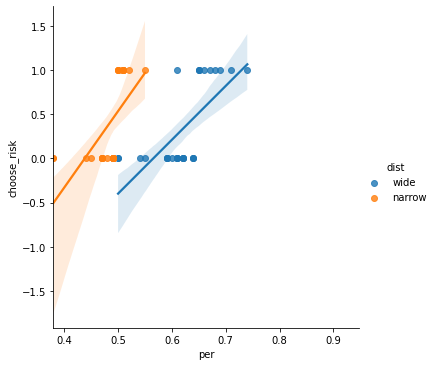

sub-613d3cb06964f7c524a78ed0


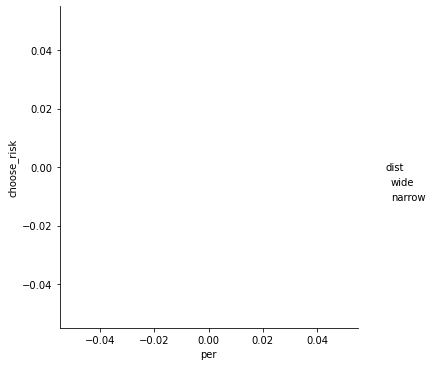

sub-59e62b6277860e0001512e14


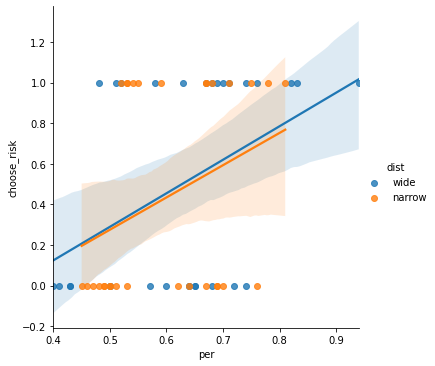

sub-6428f7ac297e312f7262d93b


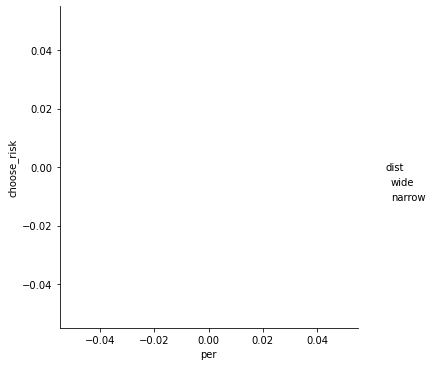

sub-62e1e3f92efe886934aebdc4


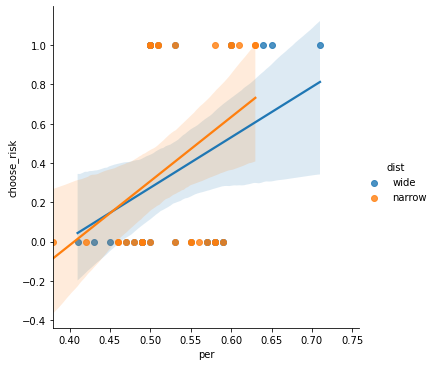

sub-5b1946322767e20001e4e23d


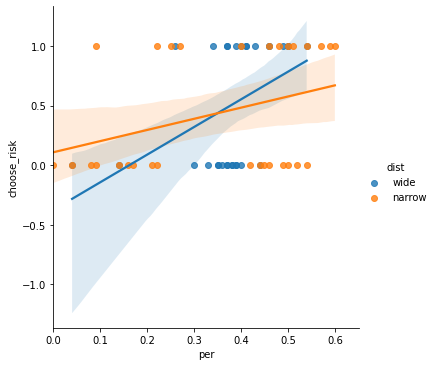

sub-5f8737c71a44ac11b9481ab8


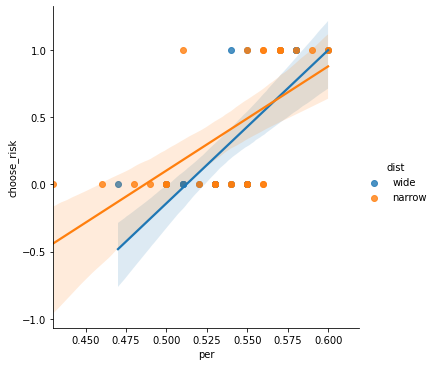

sub-5ddae85b393bd3a44d7cbaaa


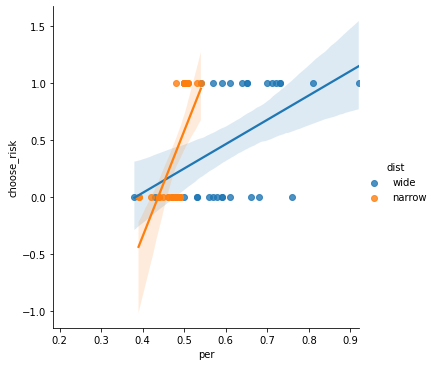

sub-63eb13f36c0fe9ba20d45234


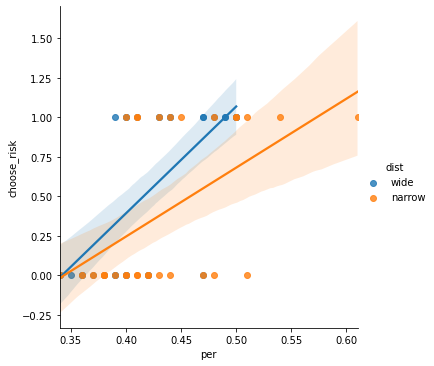

sub-58211fc787f6b90001f13f90


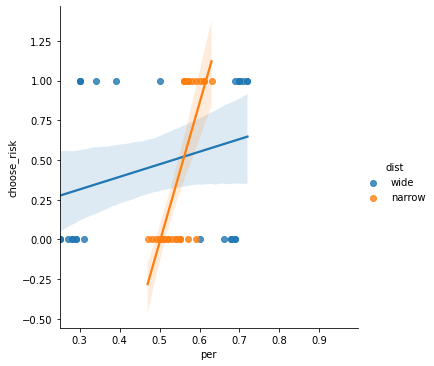

sub-5fc448edefc38a760096bb00


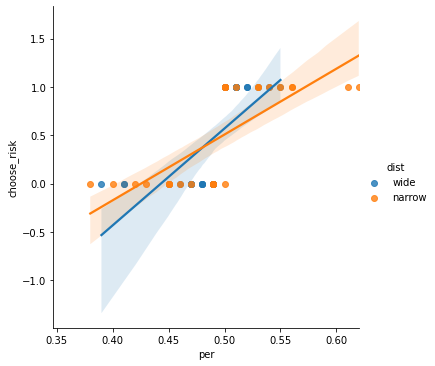

sub-5f47fd5a30f69f26b1dc80fd


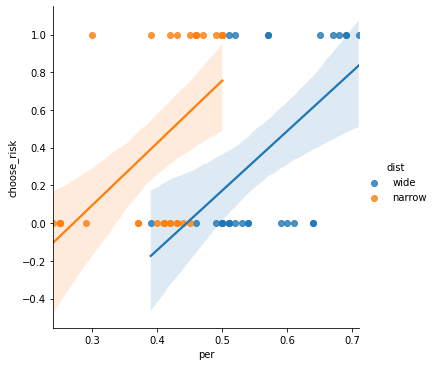

sub-5c330cefca23620001b262b1


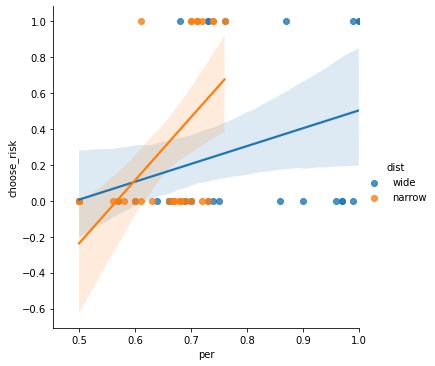

sub-63eac31811a6da58d4f32d76


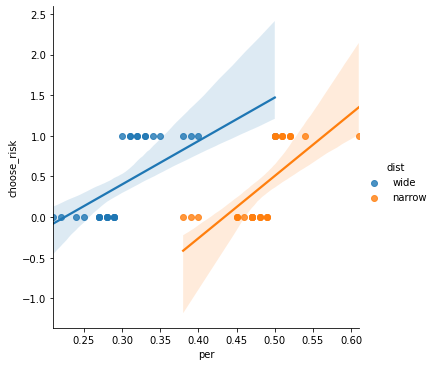

sub-629642bfde2bf56c1ec2a420


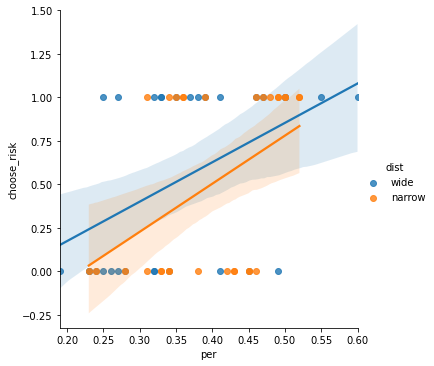

sub-58a2788898124900015923bf


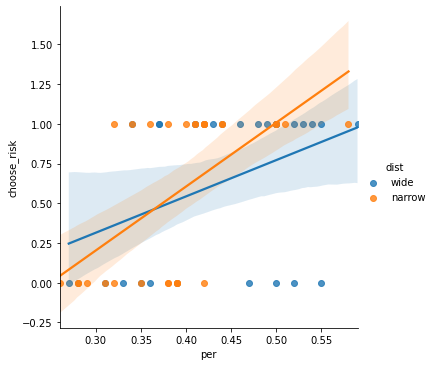

sub-60f5dc6cba19bf6145b8c921


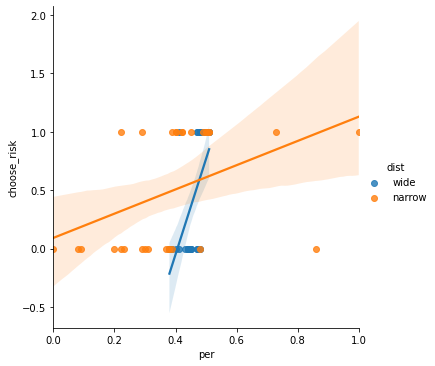

sub-610038371297afd6f2db9323


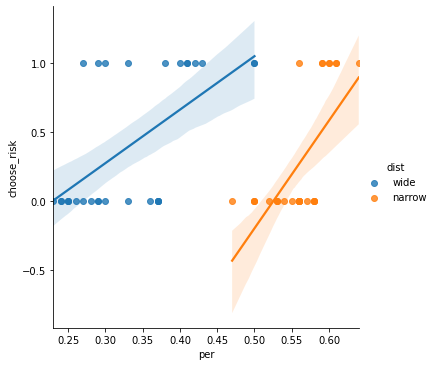

sub-54d2c4e2fdf99b2c319a8cf6


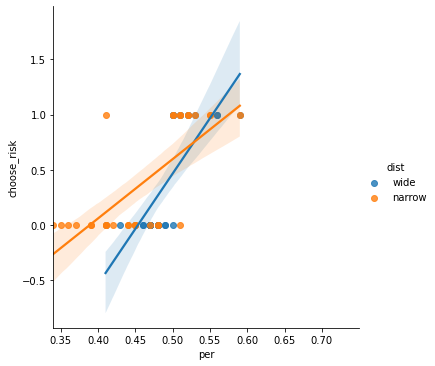

sub-62963dcc7beb938157b706ed


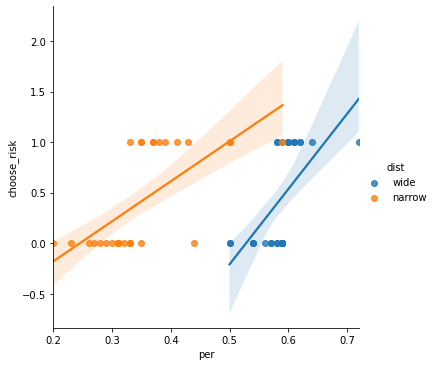

sub-561d98e03d7fe8000b0f5e09


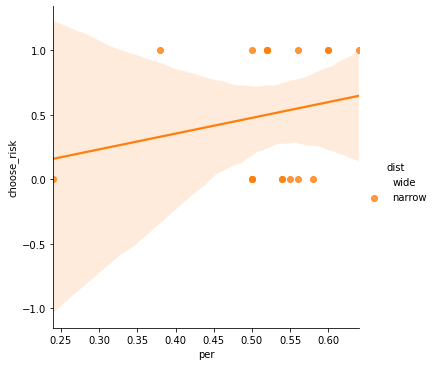

sub-6020606d7b0258677b881f63


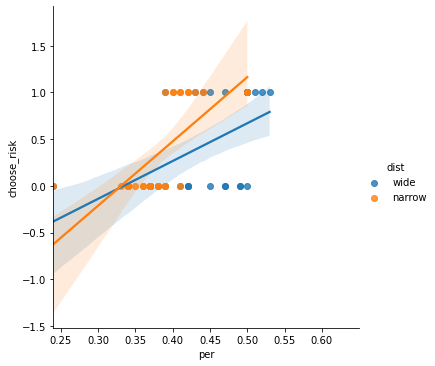

sub-59b2d1e1773f41000148789e


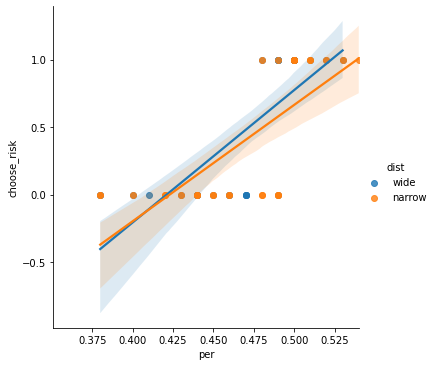

sub-63e52a02b954da8b899fa1a7


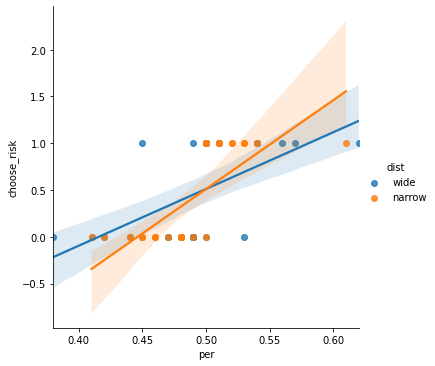

sub-63d3f9666978779139a949bb


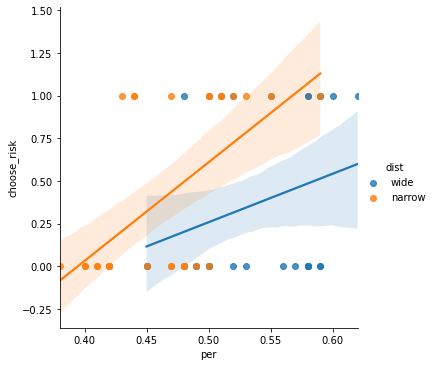

sub-63b74544b789eed26e5670dc


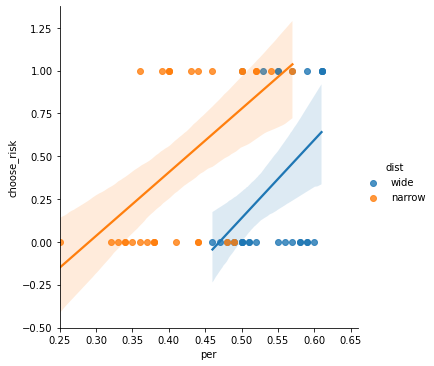

sub-5f24993238b9f80892adf099


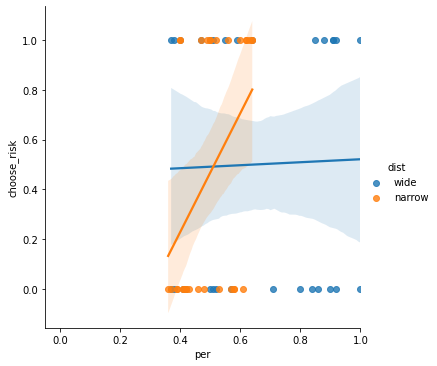

sub-5e4aff604677340127c8514d


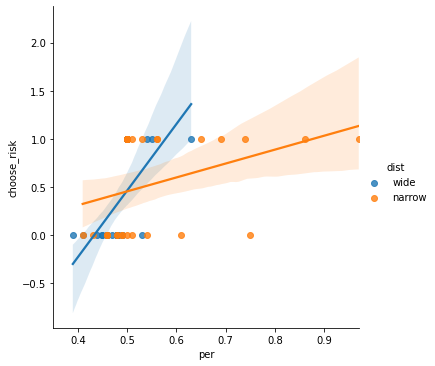

sub-5d793a152df8ed001645ed7f


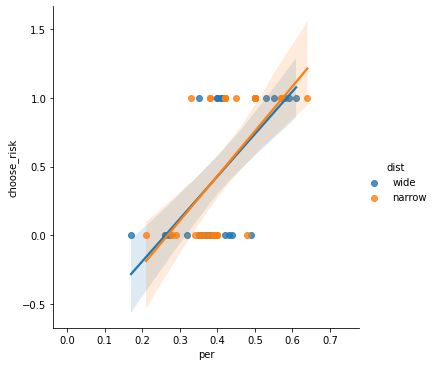

sub-6388fabfdce4b259e37e9495


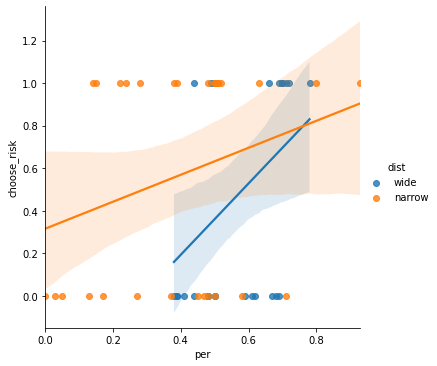

sub-61057d03e42ef519f98f4e6d


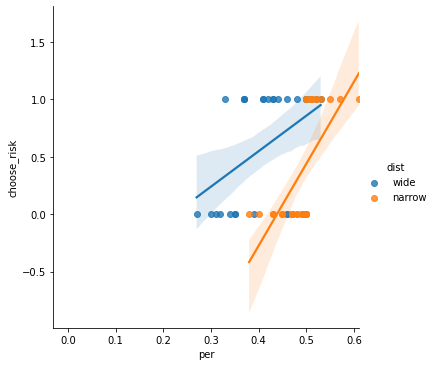

sub-58e76dbe3b2e1800012be43a


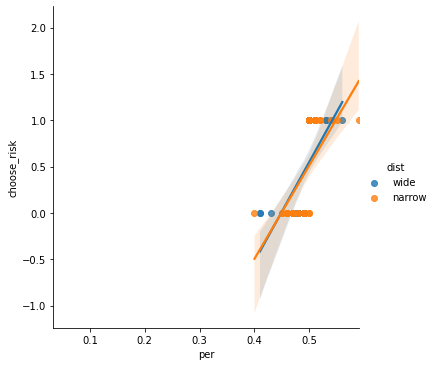

sub-6234dbba467fabd56fa59e1a


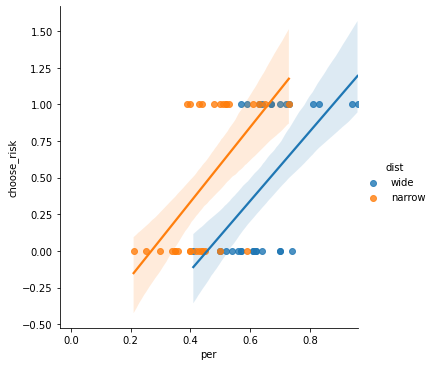

sub-5b72db405f561b0001342eff


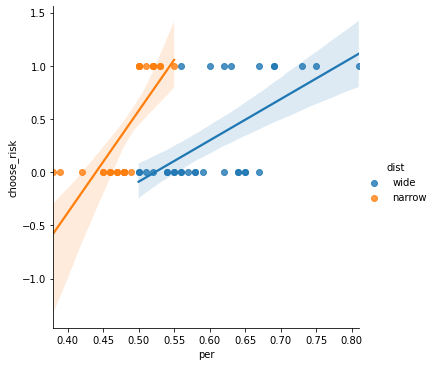

sub-5b6cd50f9ee1a50001c5f481


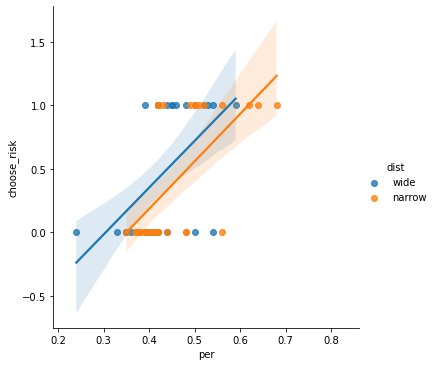

sub-5dd3eb4bc0823f3d043b96fb


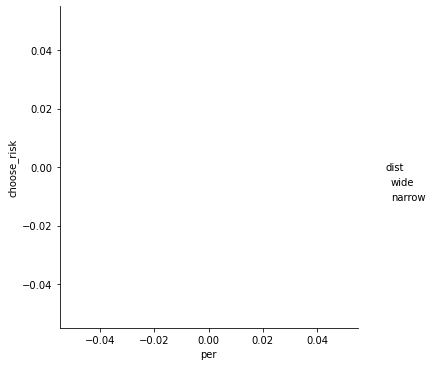

sub-63ed508fde849af6ba4b96e5


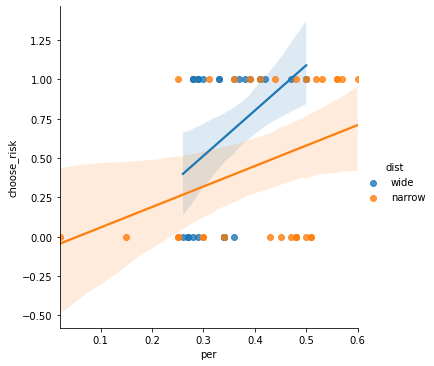

sub-63b4a880e615d21a58306118


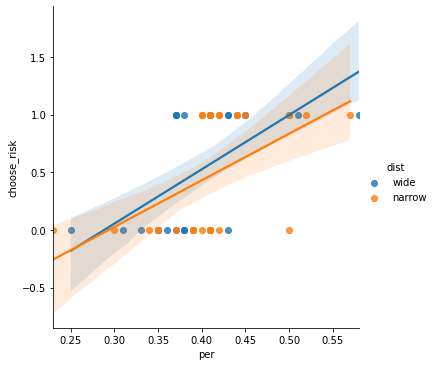

sub-5e2f4ab6fb987e078bf5f68e


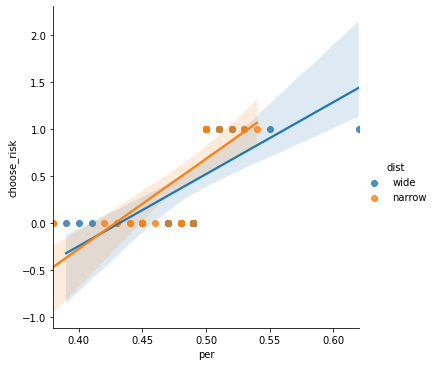

sub-5d46665905b29200188e52b4


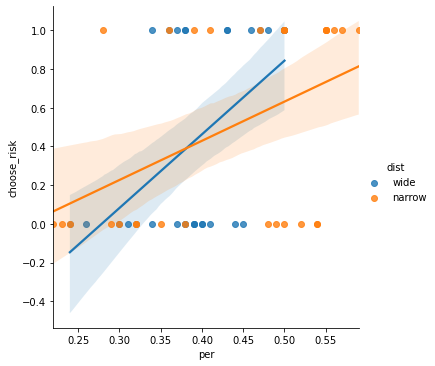

sub-5e6fd3293c76d25a3ca8b384


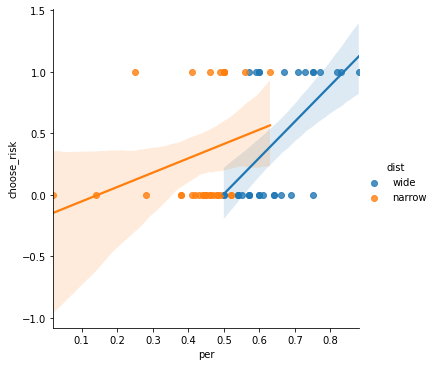

sub-63ff82a863b38f195a2f9ac9


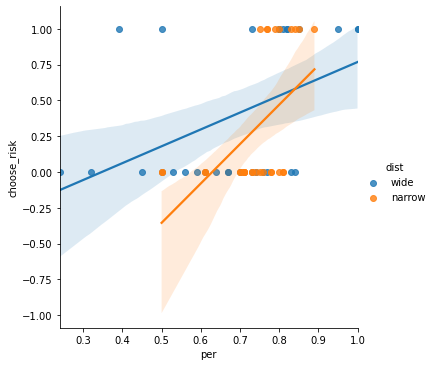

sub-60fddc61782d31b27035c833


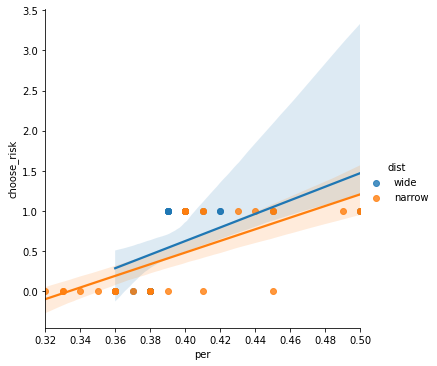

sub-60c93f189082587ea79ce324


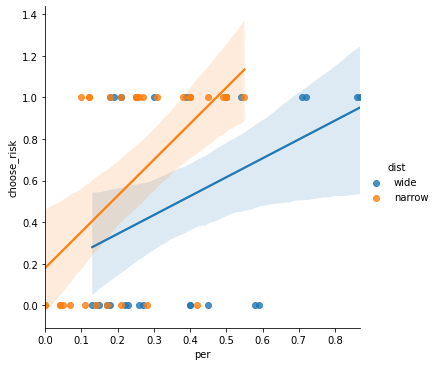

sub-5a708ef2f1530b000103bfab


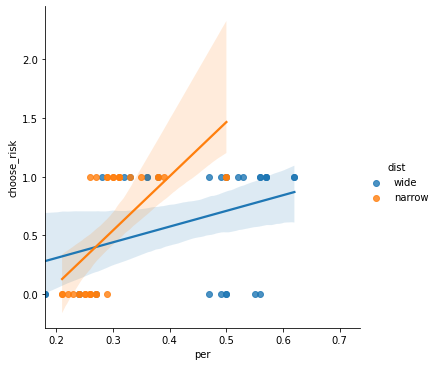

sub-637cef64a7b9fcc38ac1425c


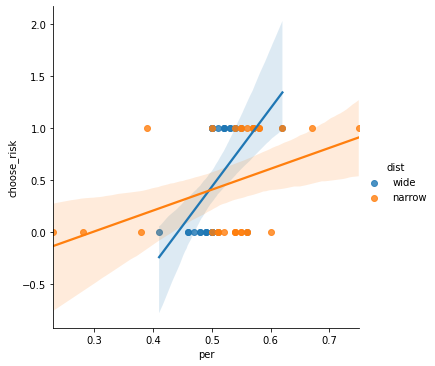

sub-60045900ccb68e4bdd23111e


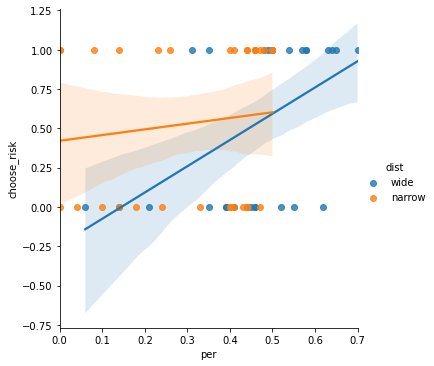

sub-62ff26509176c97c9ceebc2b


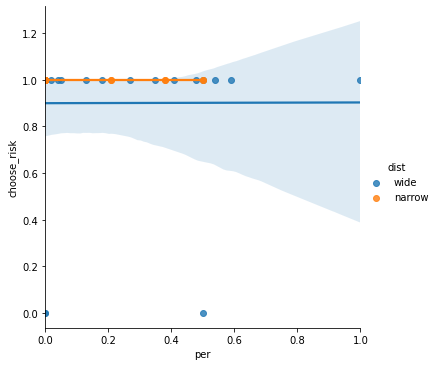

sub-63bb0d793cee514d16b866ef


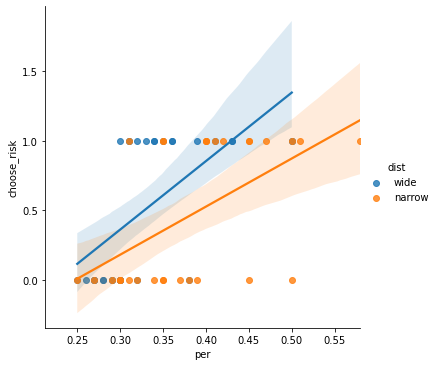

sub-5d7c49ec90d1320001d7cbc7


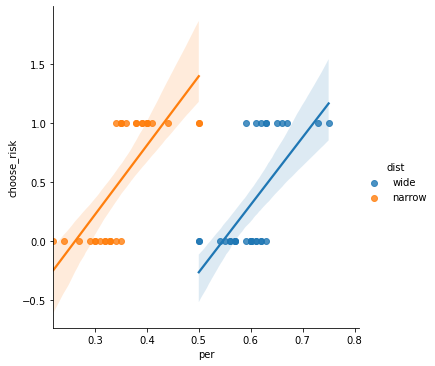

sub-5f51287698edeb30a0cf878d


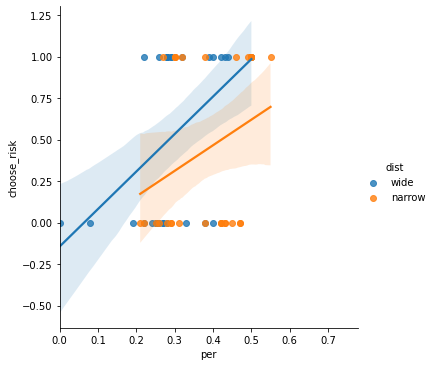

sub-607ddc576718114dea38841c


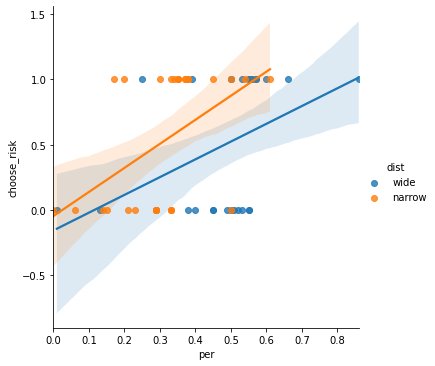

sub-645b459067ce8797bc7b4513


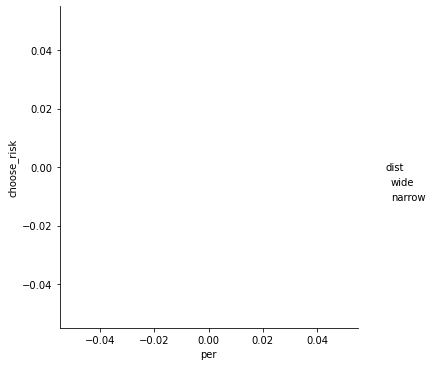

sub-64301757c18367c5ec9582fd


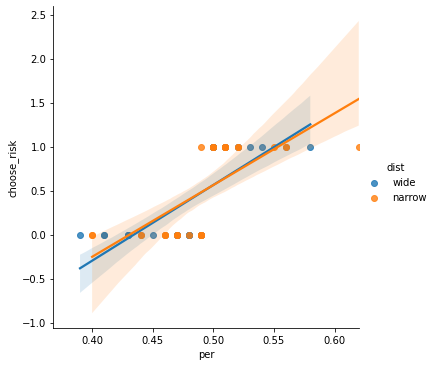

sub-633fd06a2224400c957c8ef7


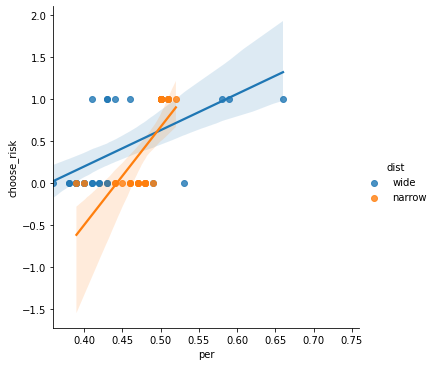

sub-602451f15e338c12534710d0


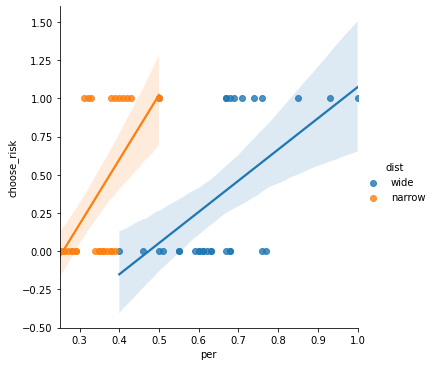

sub-5f3f5ad05ec7d1257993b196


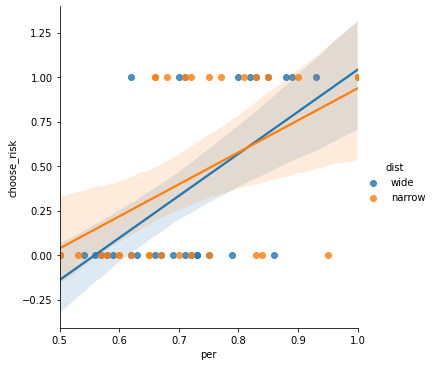

sub-5e74406c8c8f273bafab9895


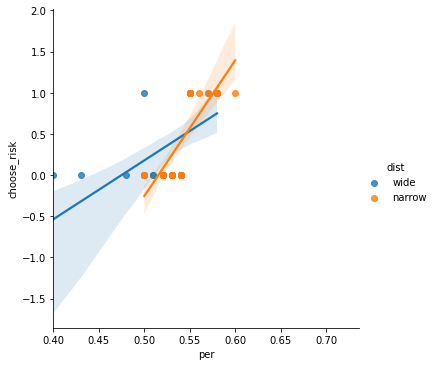

sub-63150b2e1cfa995c03244696


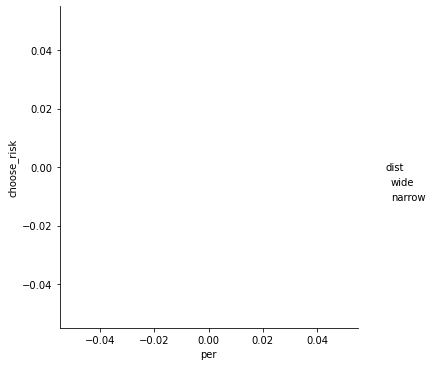

sub-558a035bfdf99b2d75651378


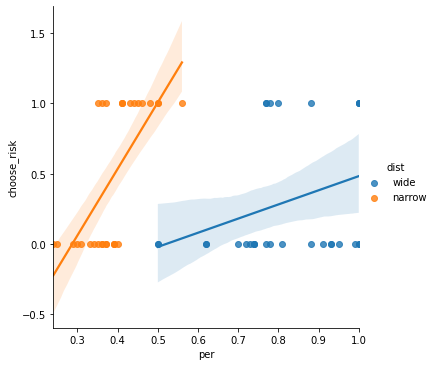

sub-62f41a3f40490ce7273873ec


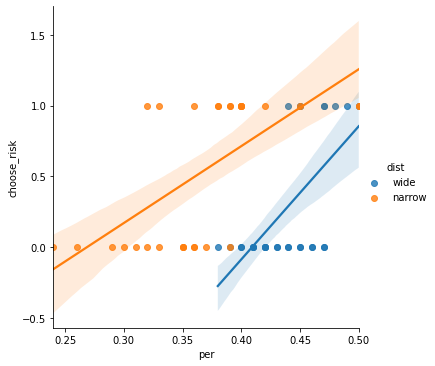

sub-610820f8cc357db69daa892a


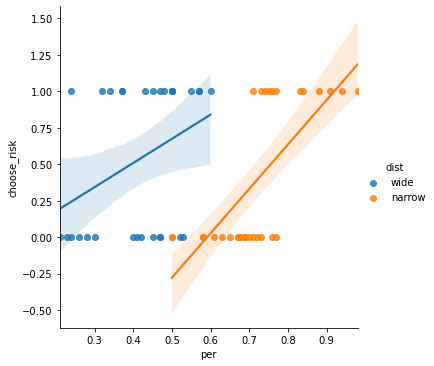

sub-546ec14dfdf99b2bc7ebd032


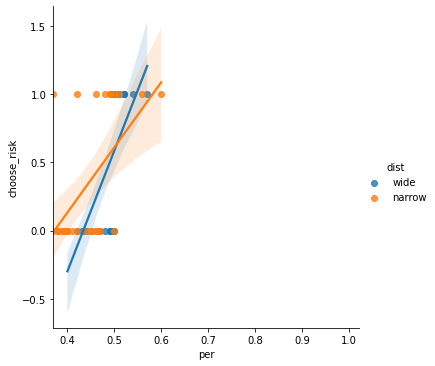

sub-616da069522e6b8aa420a603


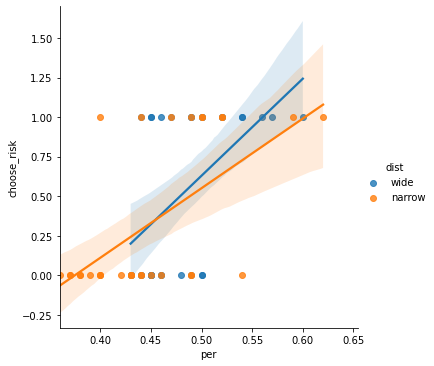

sub-63ebbd7af1c80715178e5586


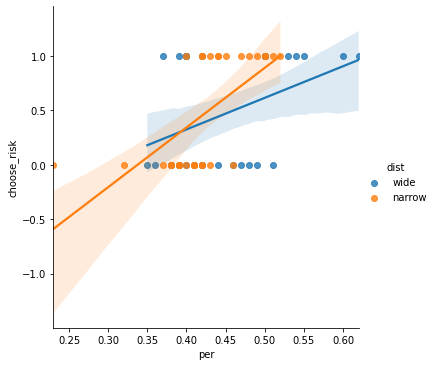

sub-5e987098f1bb6707dca13f5b


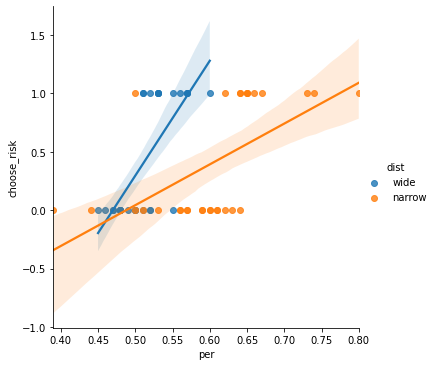

sub-58a2952076c5b7000166150a


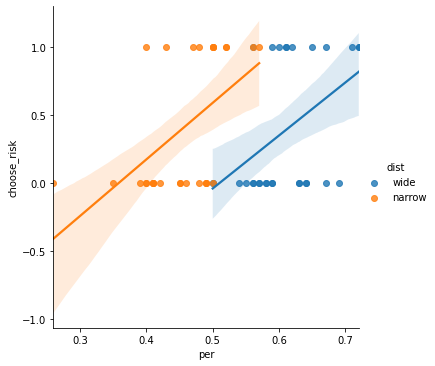

sub-5ebe015ae70ab70008895dbd


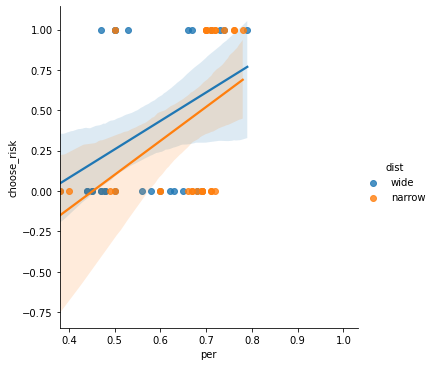

sub-5731e4005b8b06000f7e36b3


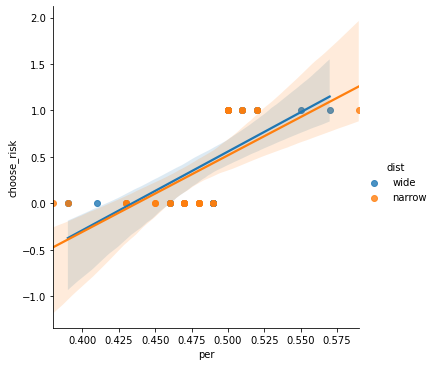

sub-63d96d5957cdd8a417721253


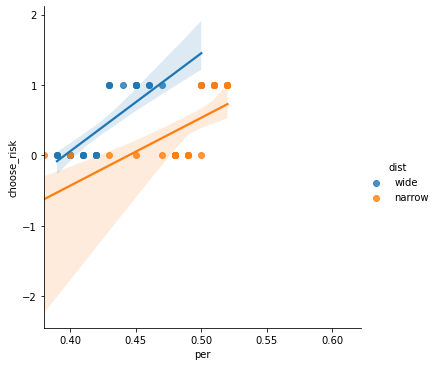

sub-5edbd29596e90d077aa16303


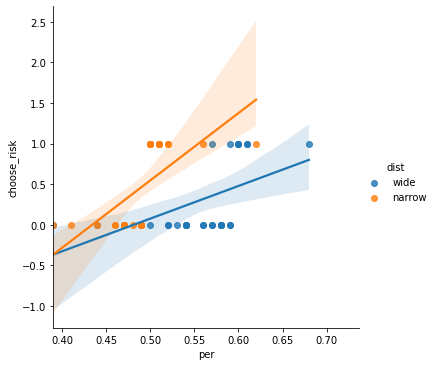

sub-6108c7b7c66ae59abfe3a96d


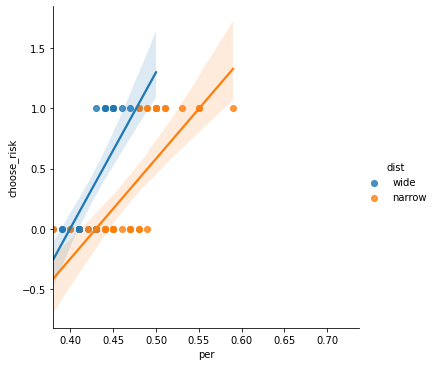

sub-5dd4189ef30aa640b4e9c094


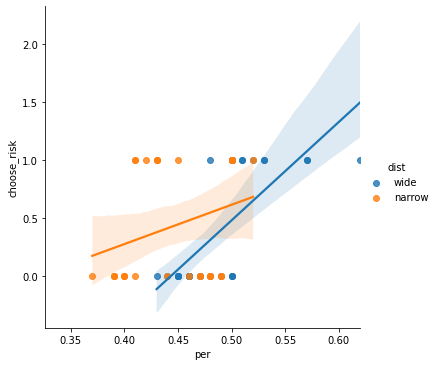

sub-55aeaeb3fdf99b5c769f1f7c


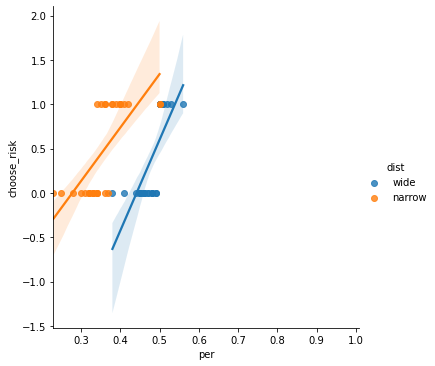

sub-614a2938ccbb6e48eb2dcbd1


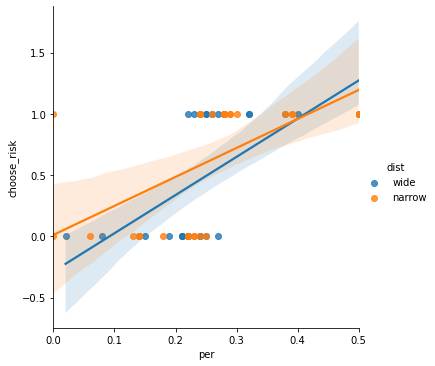

sub-63ced19b7422296653437e30


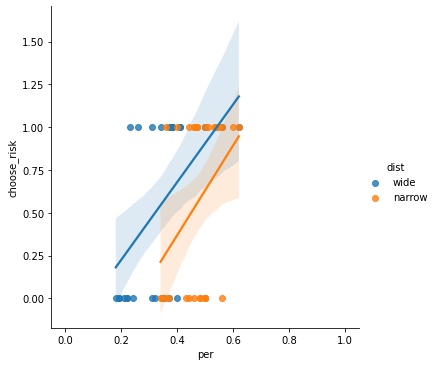

sub-62fbc9730a4b70bcc1c942b3


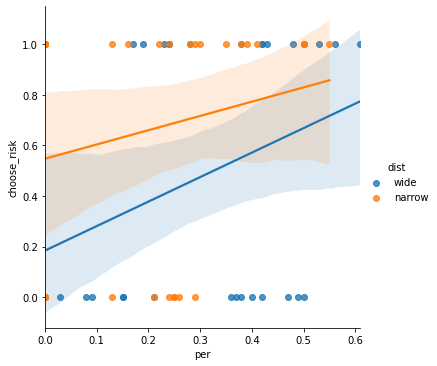

sub-5deb638bff7f7126d6fb5142


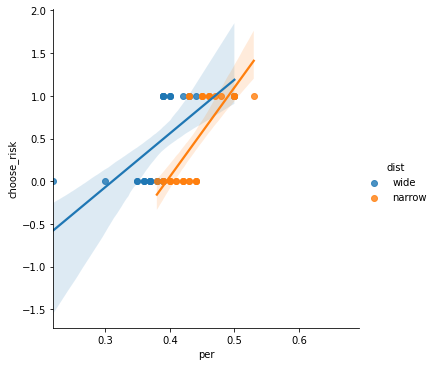

sub-629d16db307da2e64ea7b1e7


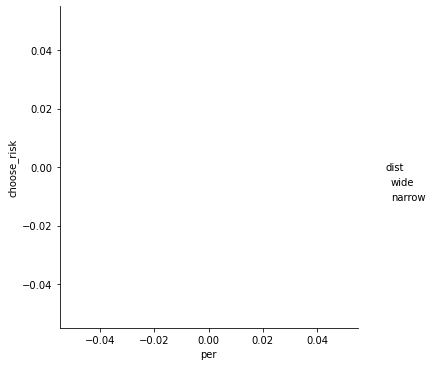

sub-5f35f5ff98f31a23b4ff57c0


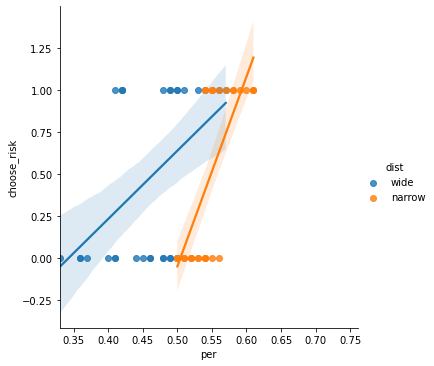

sub-5d19aa93b3e6980001ea92ab


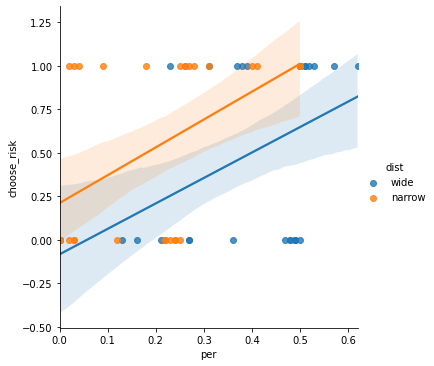

sub-5a95fee189de8200013eddd4


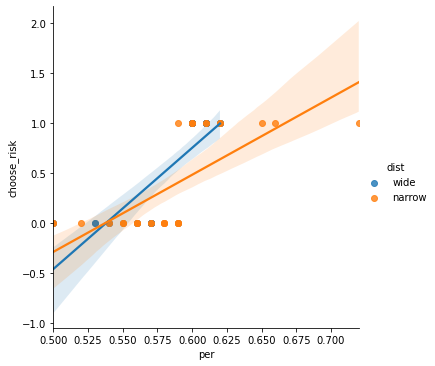

sub-5df81cd72713055bdf02efd8


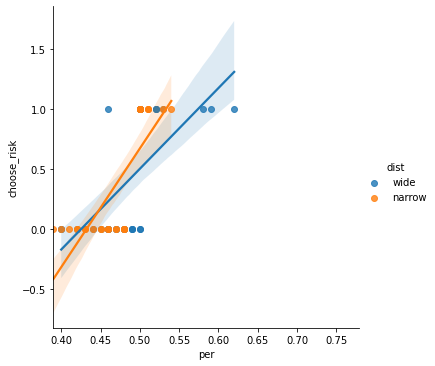

sub-5d8793d36c53380015139da9


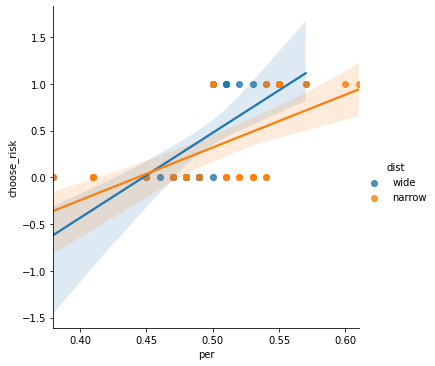

sub-5e5ae01d75f13d2efe7db45e


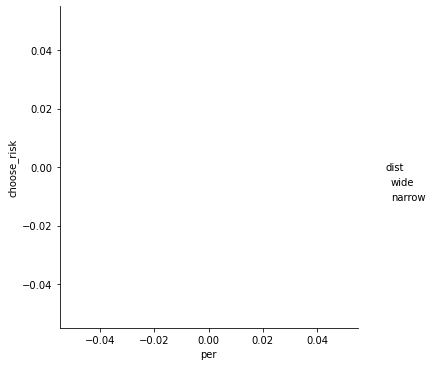

sub-5920b1f62b529b00013f3214


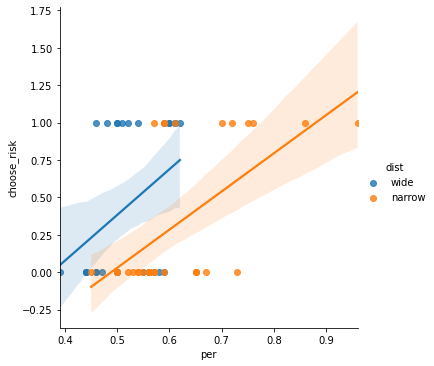

sub-62827896d034545333f4610c


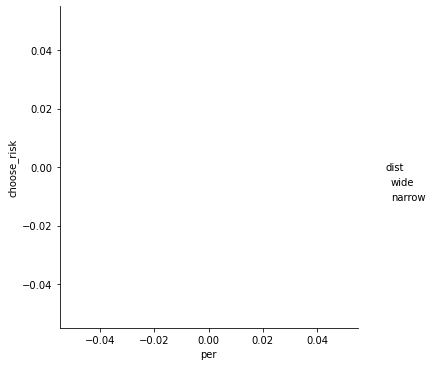

sub-611688156f6d22853511ffb3


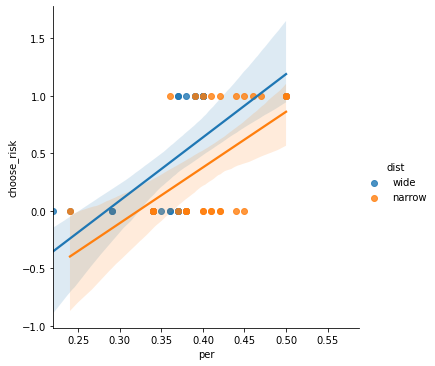

sub-611fef91a3800a9e7bfca495


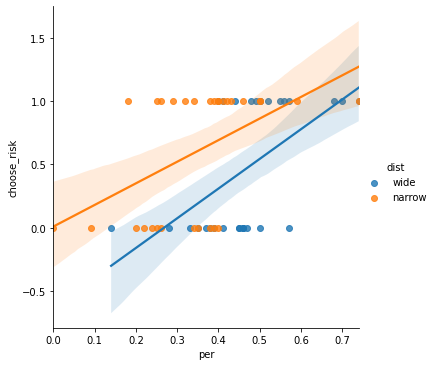

sub-55b47001fdf99b615b12d66c


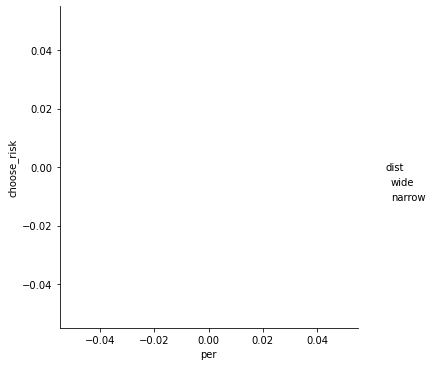

sub-59ea2d5a7f3d71000171e0a9


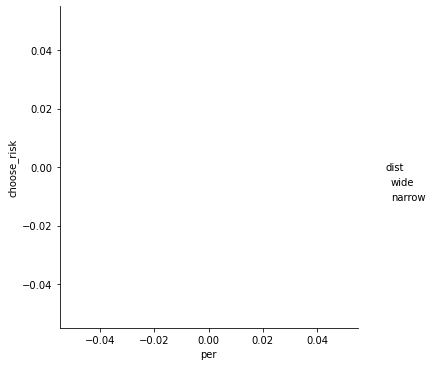

sub-615914a33224dc31f1045612


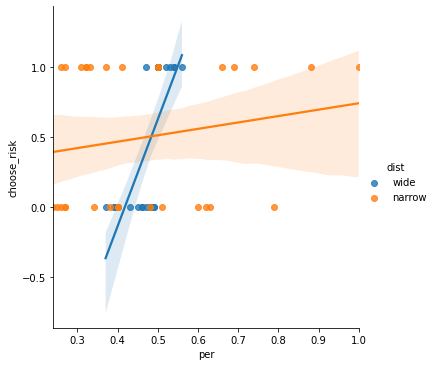

sub-5ae8d6d79b283d00017ed289


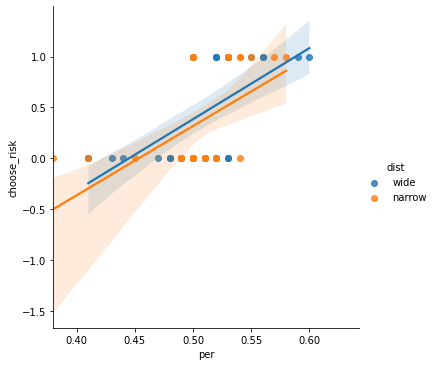

sub-63d413bee28d5ec9cbe8ac58


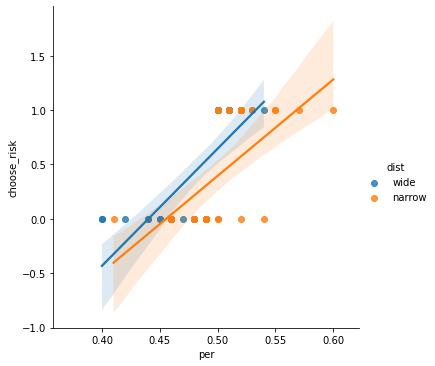

sub-60c52df5ae57d6d7918e76f0


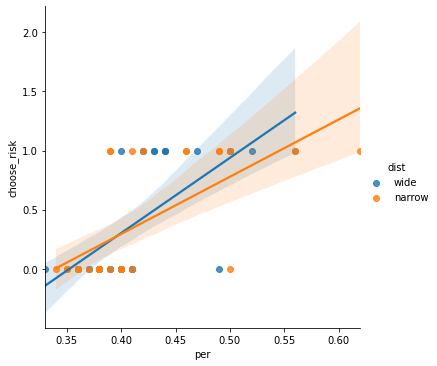

sub-5c1061cc7f73e20001186615


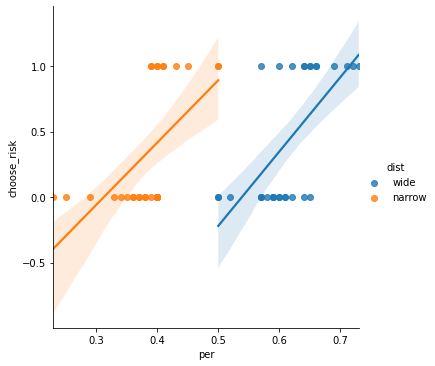

sub-5bf4afe0b8e9f800014c9c0b


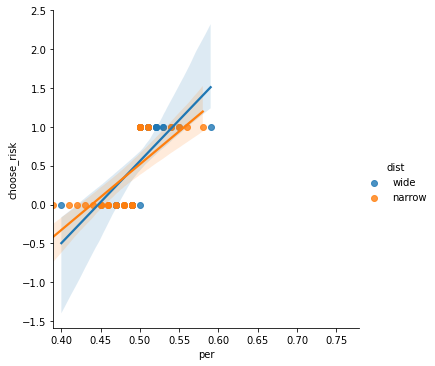

sub-62b35a7d9d9cd966ebcf3ef8


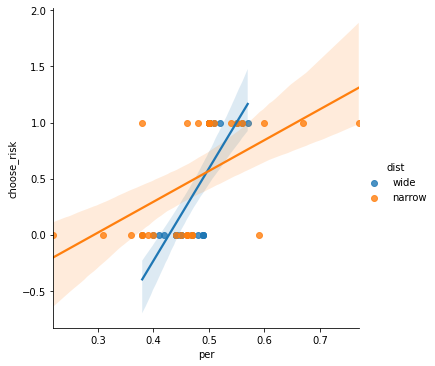

sub-63e3210e520942163bbbd6d5


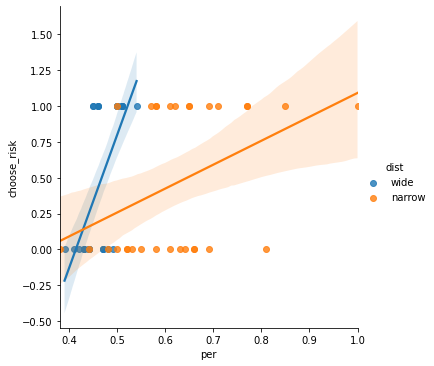

sub-5c8198fcf29fd90001a2b9c9


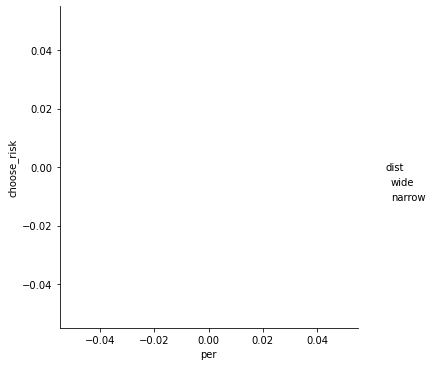

sub-5a585be8e0cf3d00012657b8


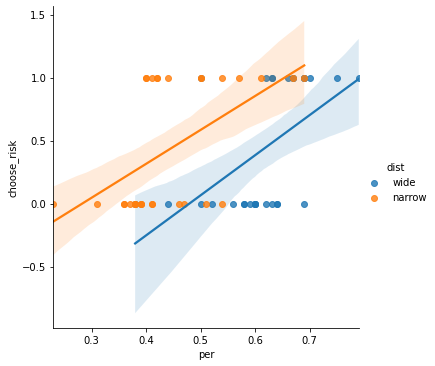

sub-5dd39758cf8e7e38d9ce47b5


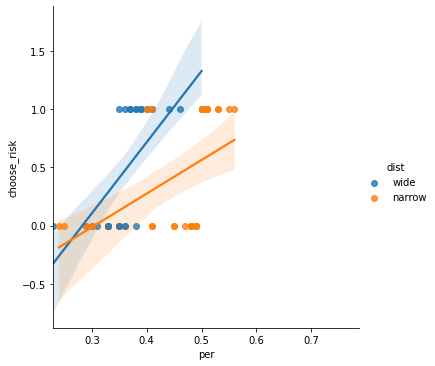

sub-5cd21eb94174960001cf8aaf


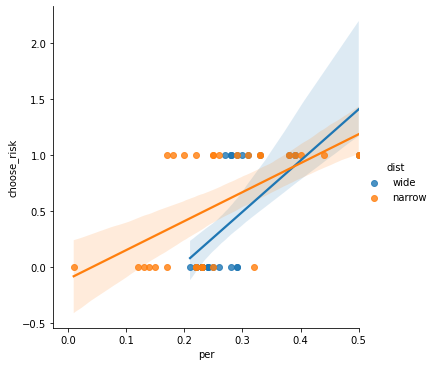

sub-62c43f3dc521456f7320356f


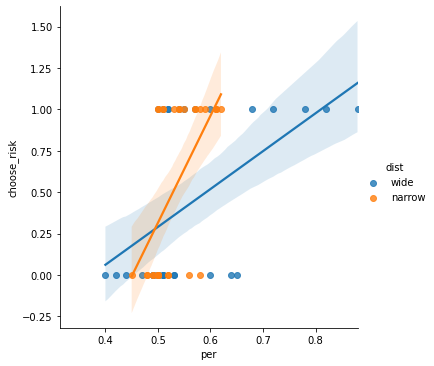

sub-62e9c91168f8d1ff048964e9


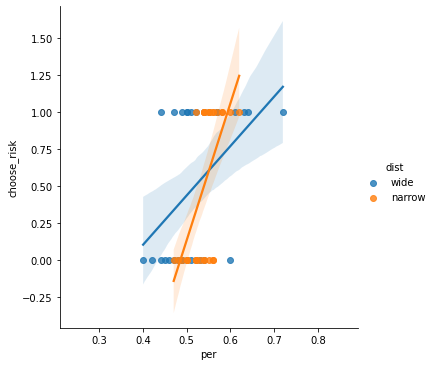

sub-5f87dcb62285ab2277e2d15e


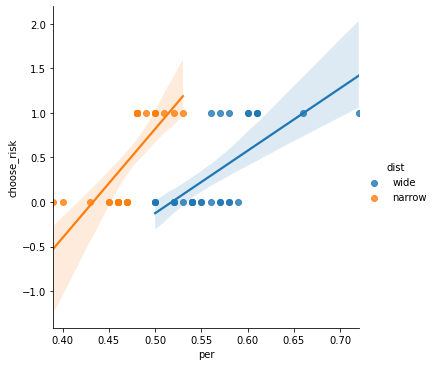

sub-5e064785e297d502d4f2b15f


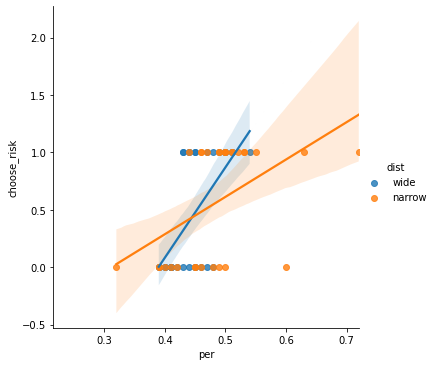

sub-5fd4ebfabf40a22bd1ffd8db


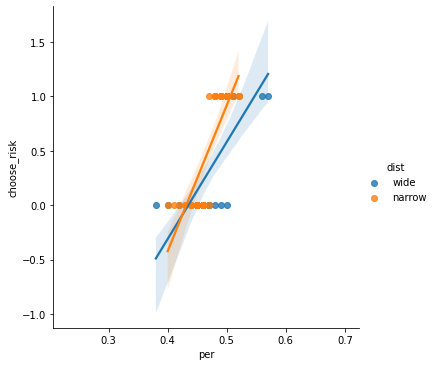

sub-60fce319094706567dd18681


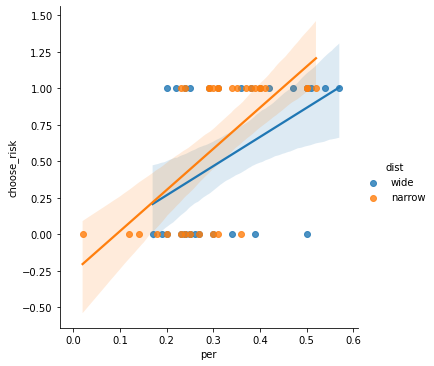

sub-63d7cb9668d2a544866a37a8


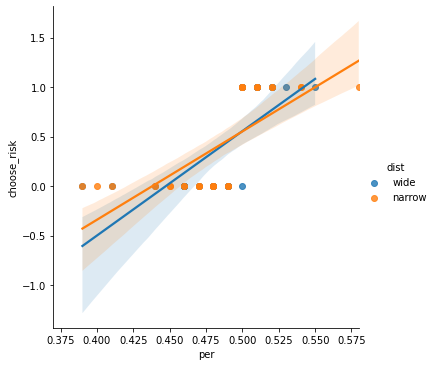

sub-6076b4987983e978f6a2753f


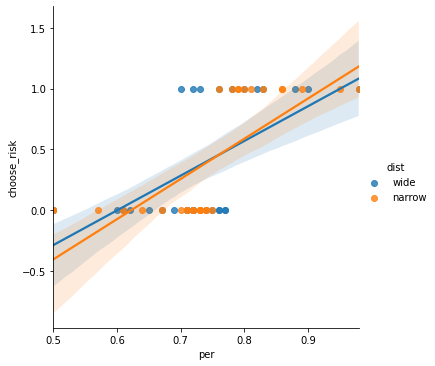

sub-636694f5d3b82c1a8279cf72


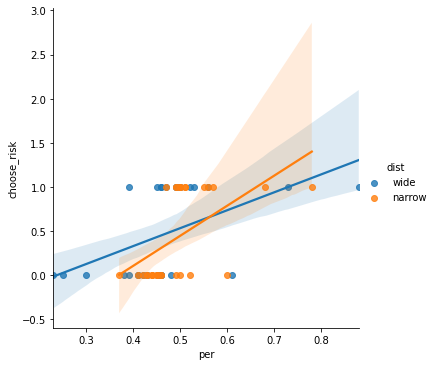

sub-5aea962d0ef2f20001858c9c


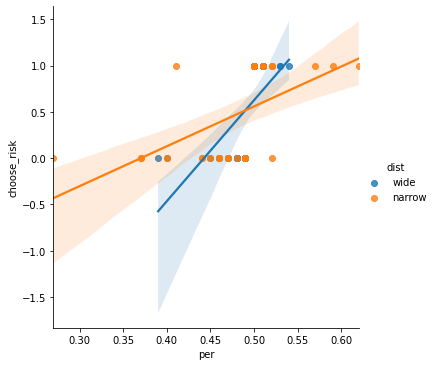

sub-5c0fcccc1f6f150001487111


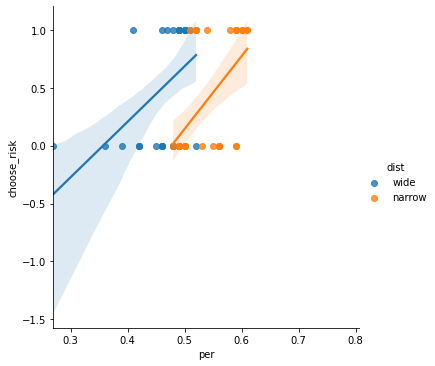

sub-5ec5a705a9b68d5f1f482ce5


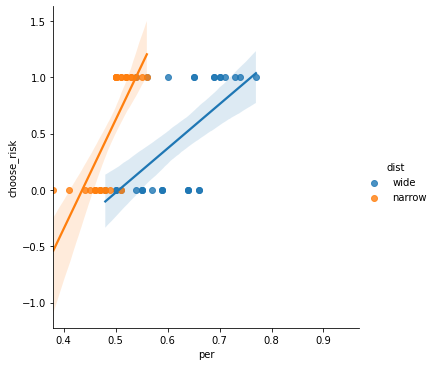

sub-5cd1a619240bc80013310b4e


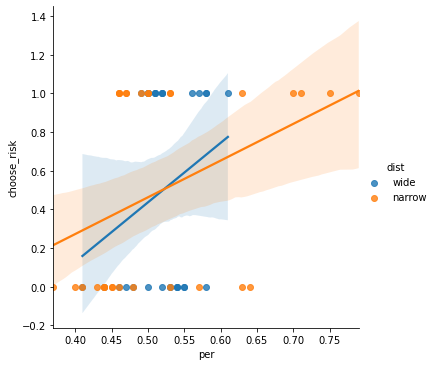

sub-63eaa6adf989350fb6225d79


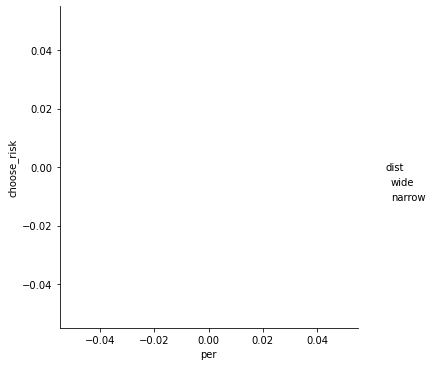

sub-615de65ccc6b16aac18a20d8


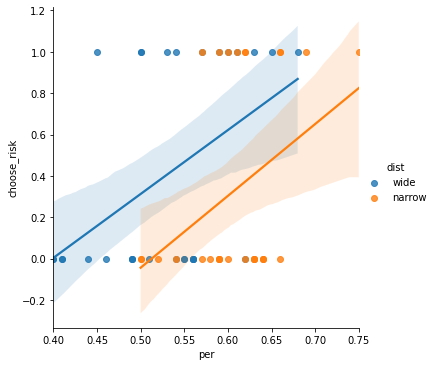

sub-5e753094e8a6f10a9805ed9a


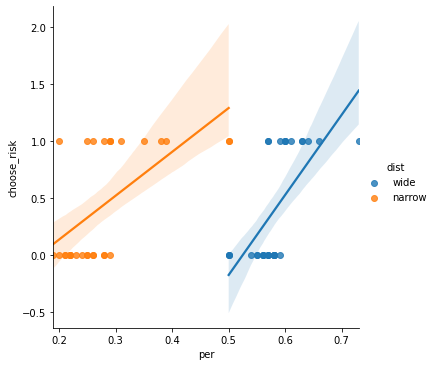

sub-61033fc15ac7c1264636395a


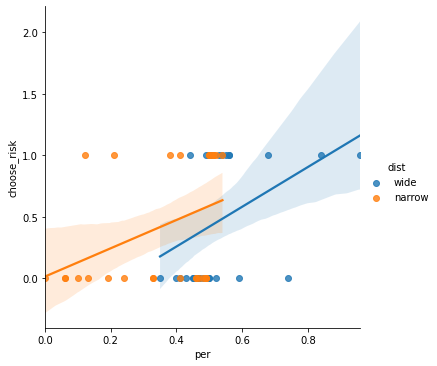

sub-615859547c3d088e8fa5384f


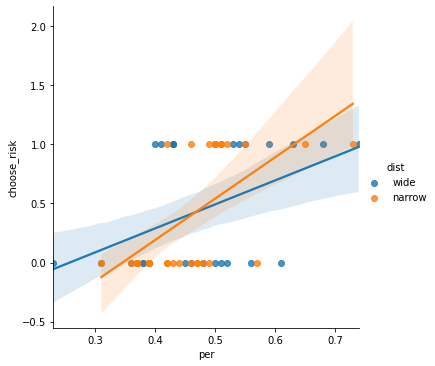

sub-5de301515253b03390043d12


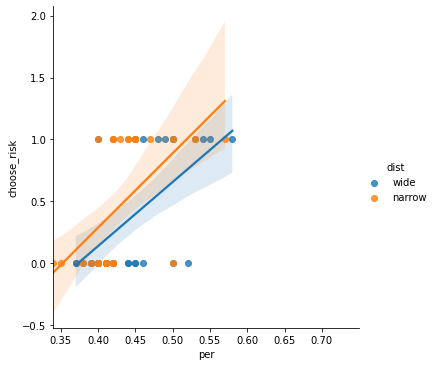

sub-631a68ee10ec68377cb03457


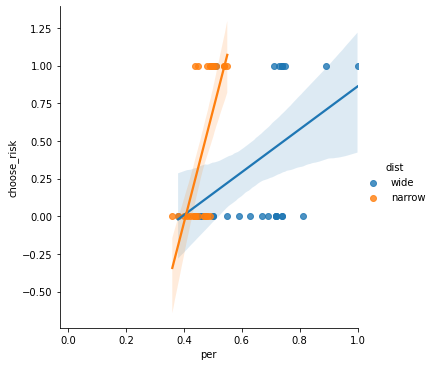

sub-6286883dfdadd2d772aa2a72


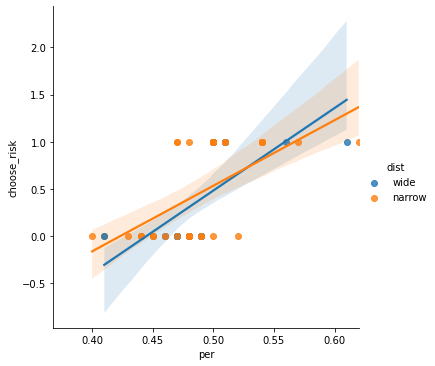

sub-5fb9b9c1c62f408e51e09e32


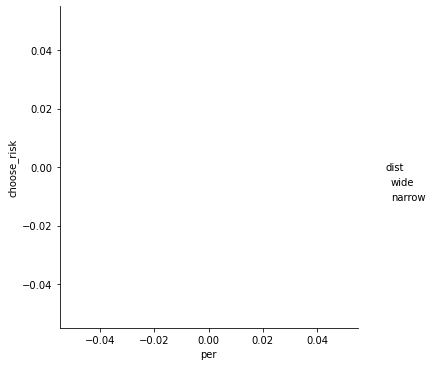

sub-63f2e107c4d0bc684b99d2c6


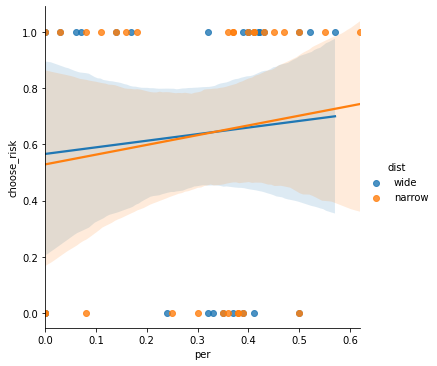

sub-5c49d511cdb1b7000103af85


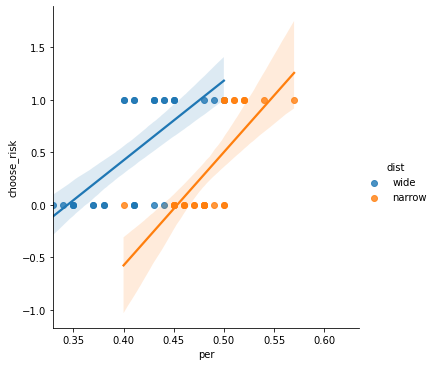

sub-63614ad9841a7d16ad04512a


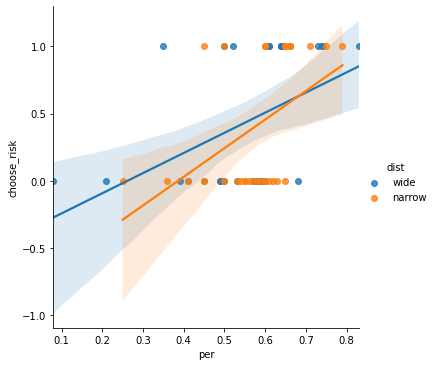

sub-5a04869ff2e3460001edad2e


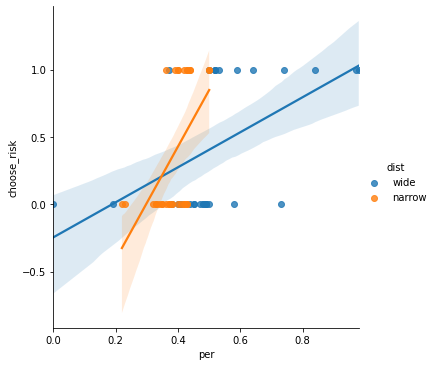

sub-60412f7a5f580407f8e6e615


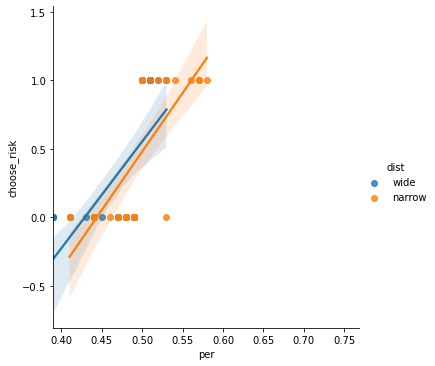

sub-627161ec9a2c16ab6496e364


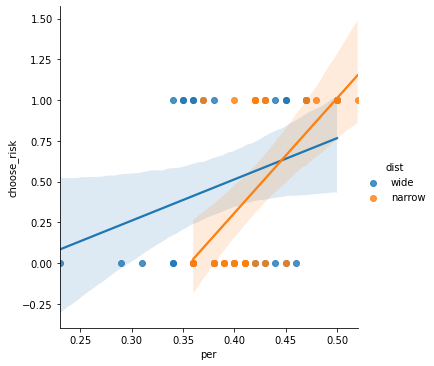

sub-63a4a1d16970d438c0314bd9


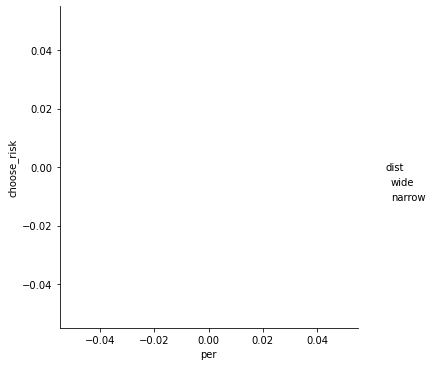

sub-61007fcba727114e471e0b78


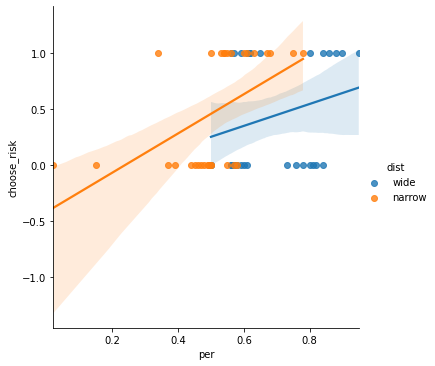

sub-645bf81e7162b9ec4cb8aaf6


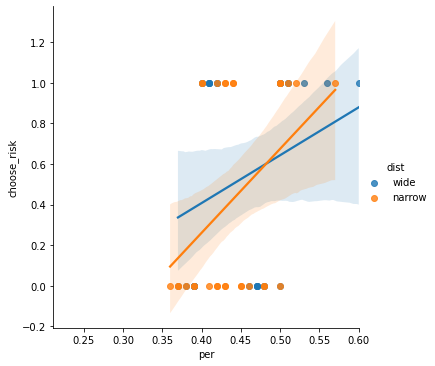

sub-5e25ab331c55ad7f7e8829e1


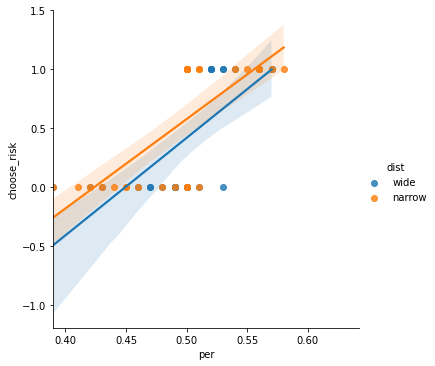

sub-60902e88302a1bdd580019d6


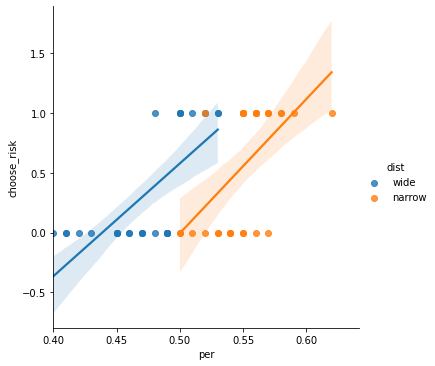

sub-6110d72aa69d55efca97d465


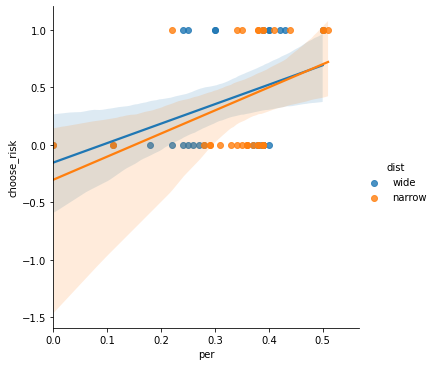

sub-6365ab361b71daa9f0eed7bd


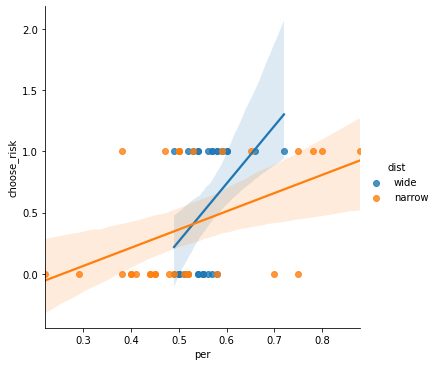

sub-5be2beac398f560001a58df7


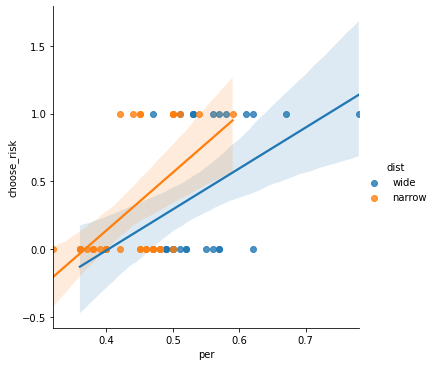

sub-595d516e2da9c90001d7d200


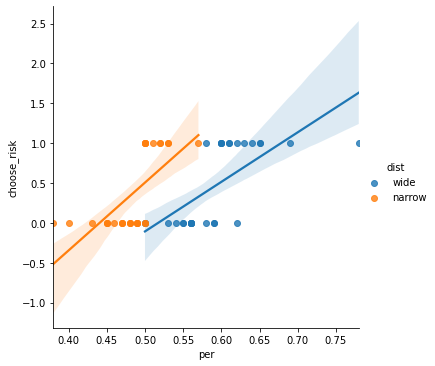

sub-5cd321750316ed0017c81bcd


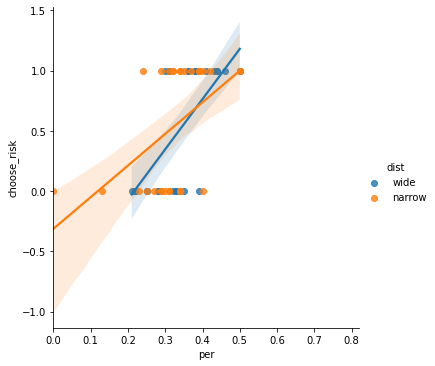

sub-5e544727059e3744ccdd4c3b


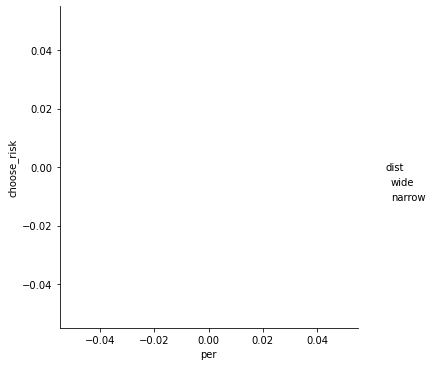

sub-6267ec348d99cc16e7beb7f7


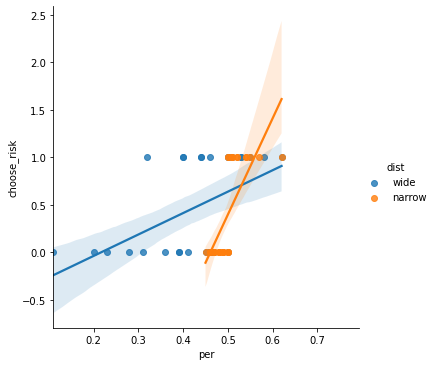

sub-5ddaa1e583e309a04100bd57


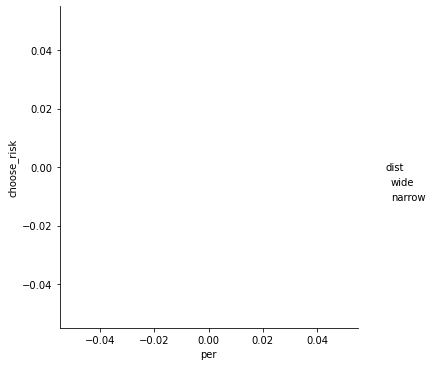

sub-61fa94015719bc09cb834e2e


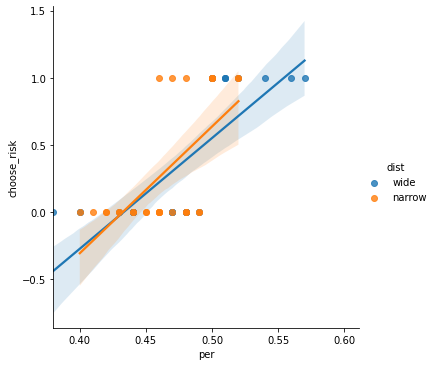

sub-5f63aebda80cfc0db6982f74


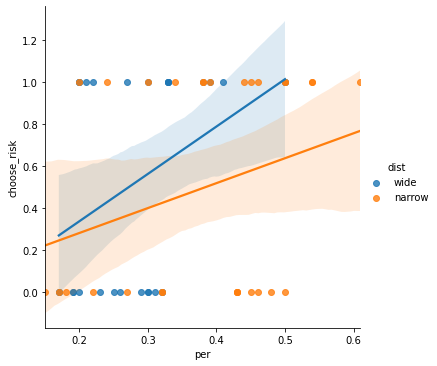

sub-595bee9282be5500017ad683


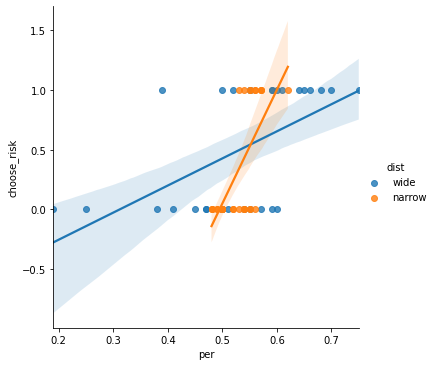

sub-5d9ae3ff9d2a700014869bcb


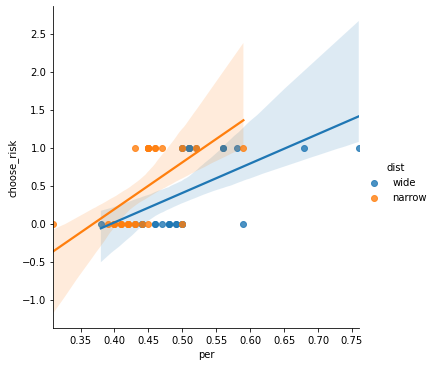

sub-608c75be6bf5ca1f23ab35ad


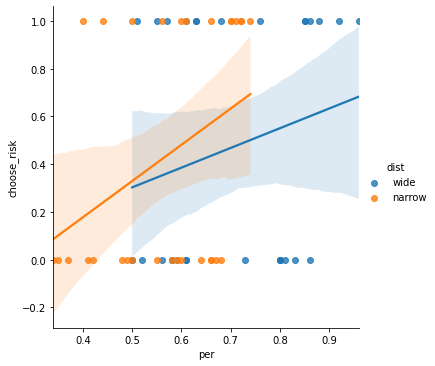

sub-6272aedf6abac2a395291522


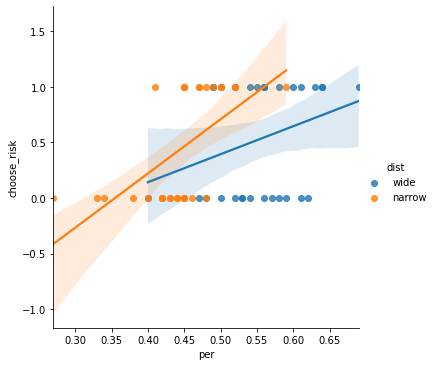

sub-5bca53970f10750001d75a8d


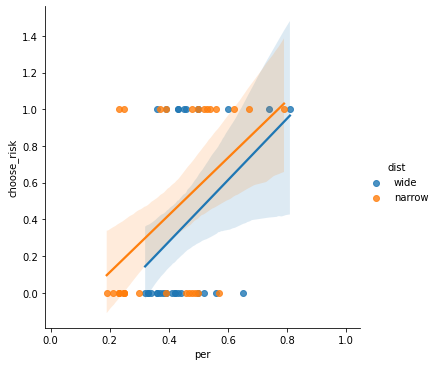

sub-633dcb03b88c879182663618


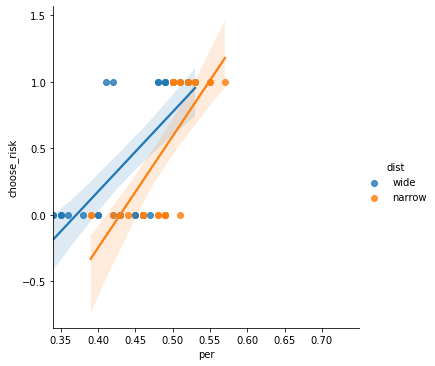

sub-5dd329e3270f4433de53299a


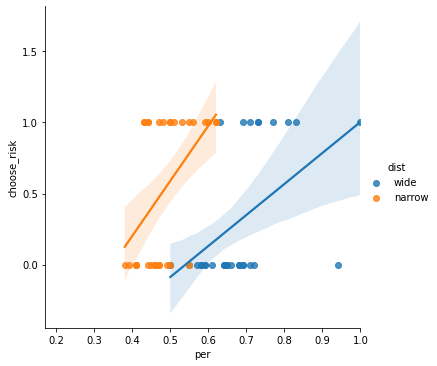

sub-5ec14623eb82d302356805c5


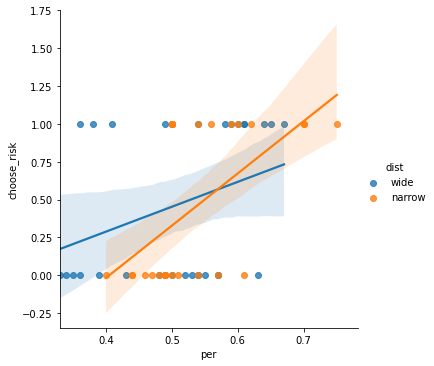

sub-60fdd6065200f6120a01fba5


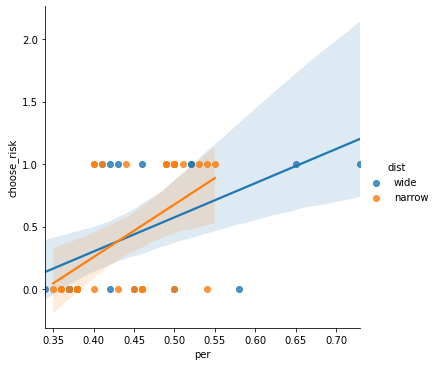

sub-5f8a1fcf2773900d456a3e70


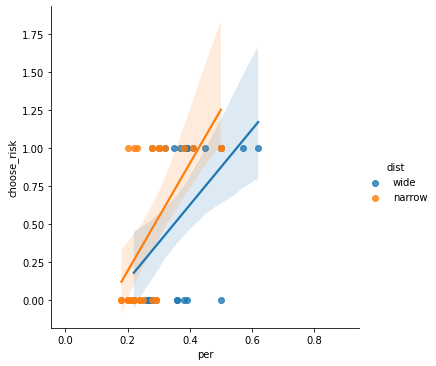

sub-6134d9cf96a9c6192e24866d


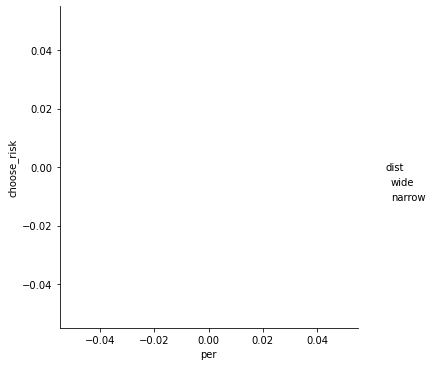

sub-5d28ec37d7d4940015e62beb


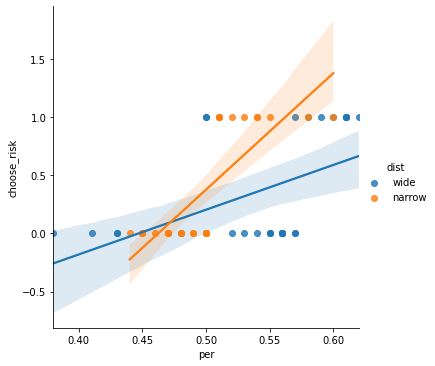

sub-60fcfde8842d3a8a5a139726


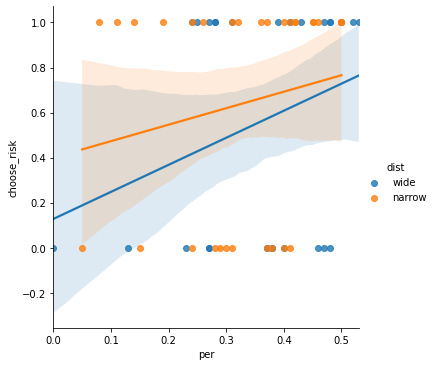

sub-5cdf2adac194e800187ad97a


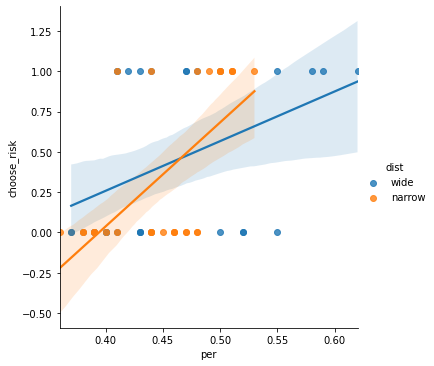

sub-5bdc8d12b2fff7000189b6f8


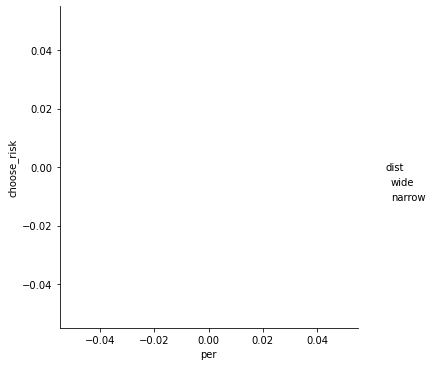

sub-6110de9b4f5ac5a4399c7b46


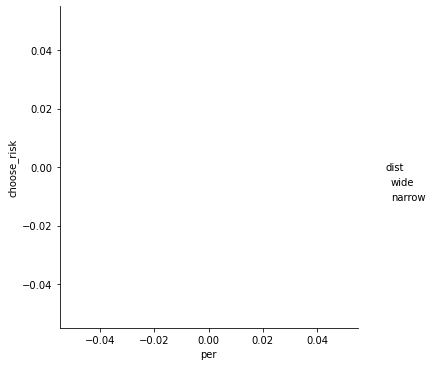

sub-631634c04e43861585e07b87


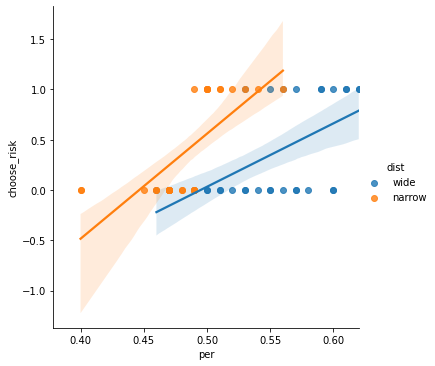

sub-61fa94735719bc09cb834f49


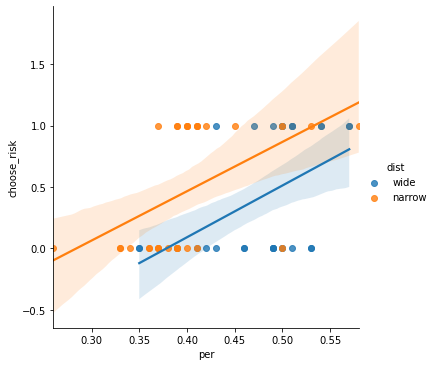

sub-636148b49f7e6e857fde4001


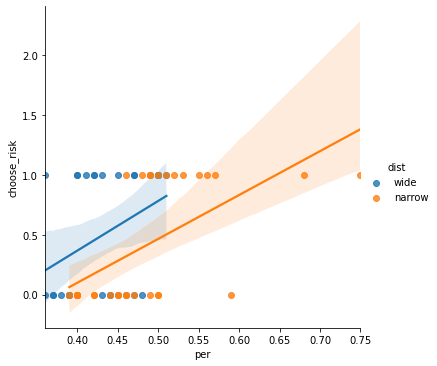

sub-609122350e5b8e743ab41f79


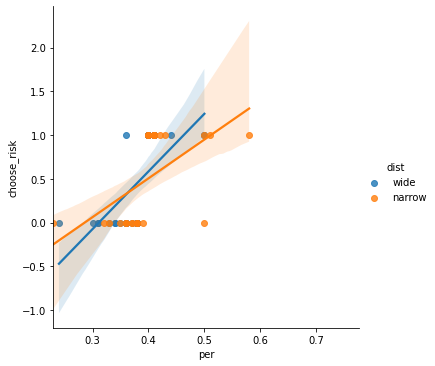

sub-5b98d9362cca9c0001de161f


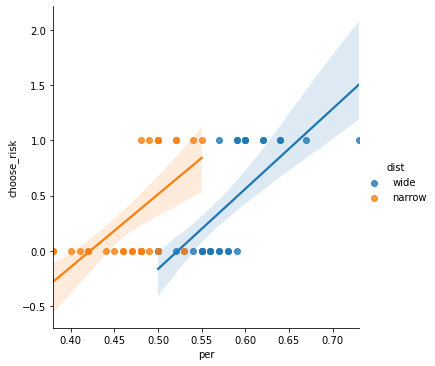

sub-5db9e7ae0b530c03b47f6398


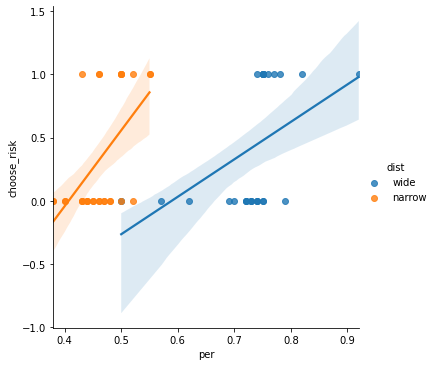

sub-5efe4033859ac314b6d79a50


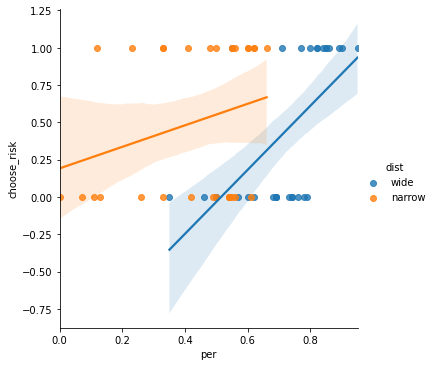

sub-5b824fb6cc06660001a302d4


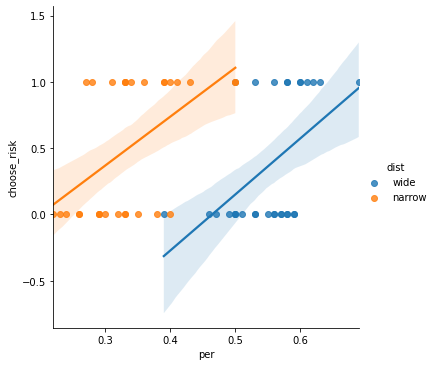

sub-63652b3ed1f35f8e04325845


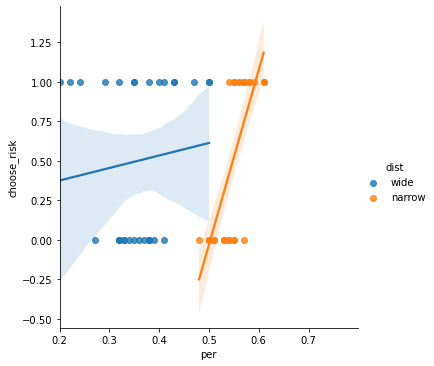

sub-610ad34844dd2b51bf5d87f5


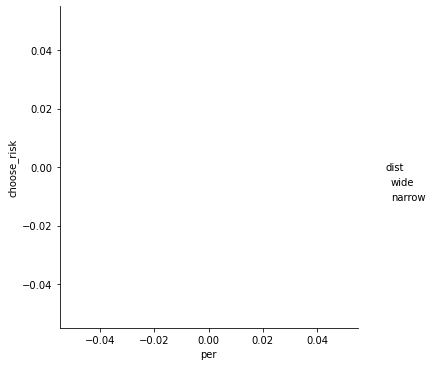

sub-60bac4eb11e08e852fd030ab


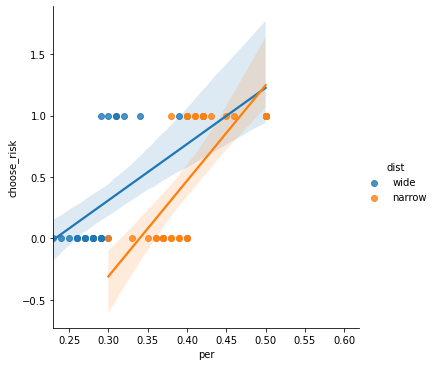

sub-569916e4b0e16500050131b4


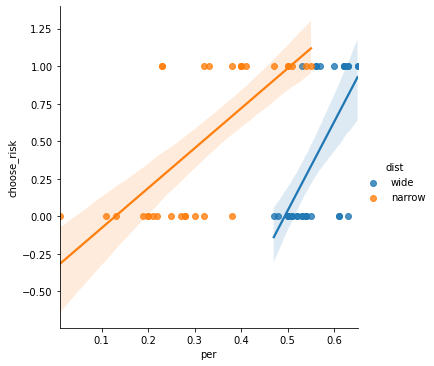

sub-5f09f9a38bf3690ea1c20c96


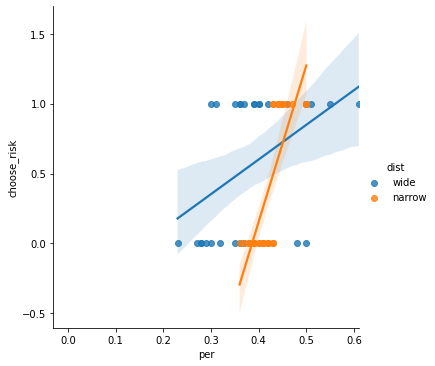

sub-636558deffacf6b4af41ae6b


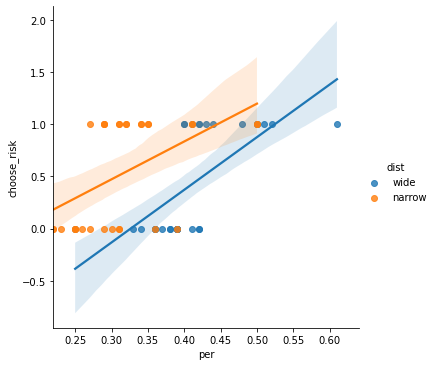

sub-63619eb02e5bd8f4f7bd138a


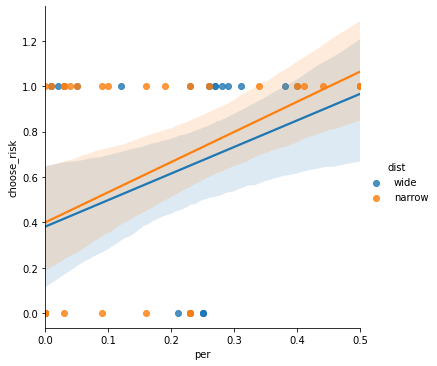

sub-59278c090220760001fda664


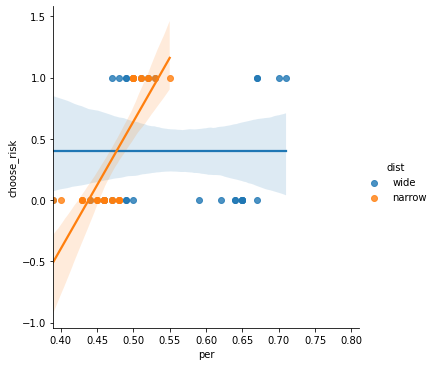

sub-5bca2688526bab000199550a


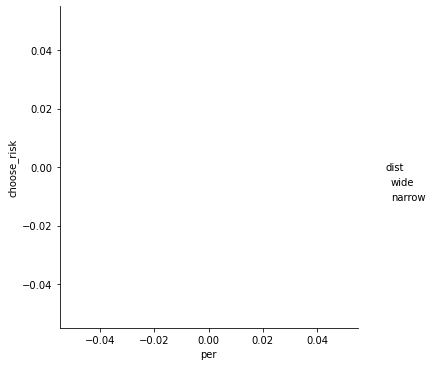

sub-5b0d1b8e444cef0001ca66ac


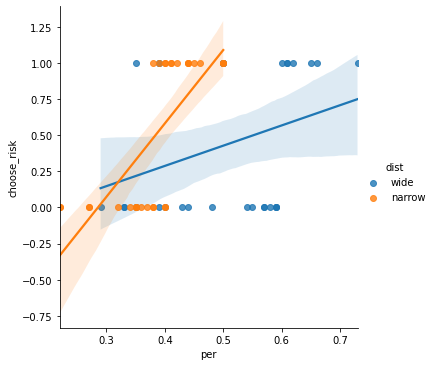

sub-57e91ff08dcd2c00014bea18


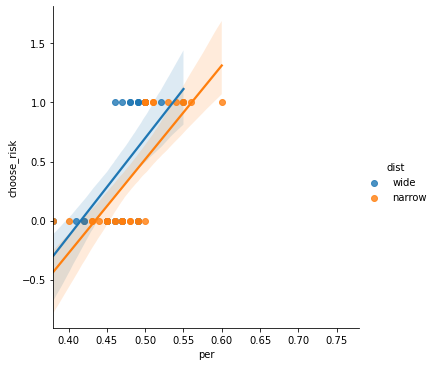

sub-6115d535dbd6948950e5441a


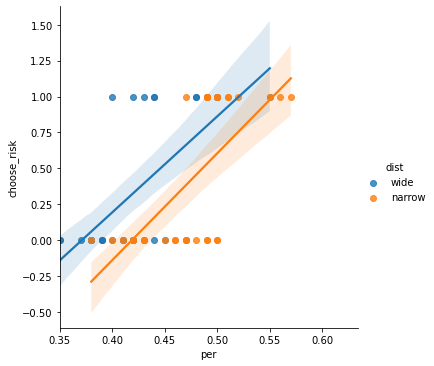

sub-6402618738abc106f32f8928


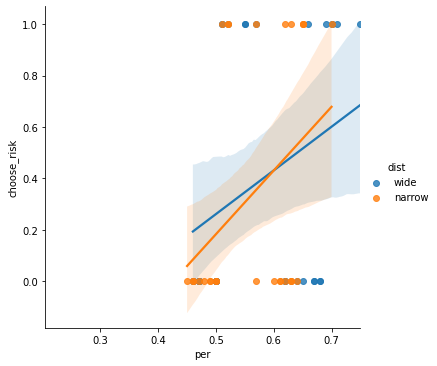

sub-5bd47734506cd3000101d181


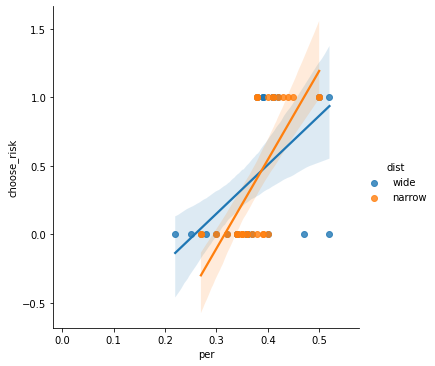

sub-62a33f5217536a32157d874e


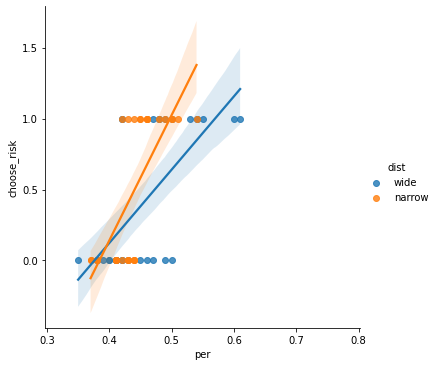

sub-5cd34d42fe890a00174debb5


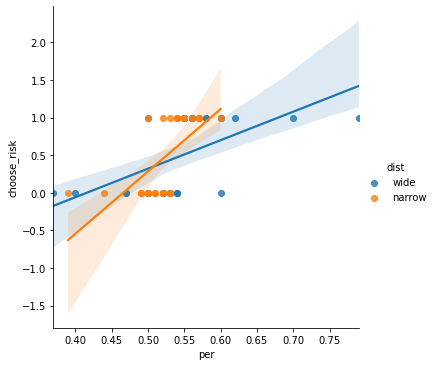

sub-5ff38b5a46872e981d2f7bb2


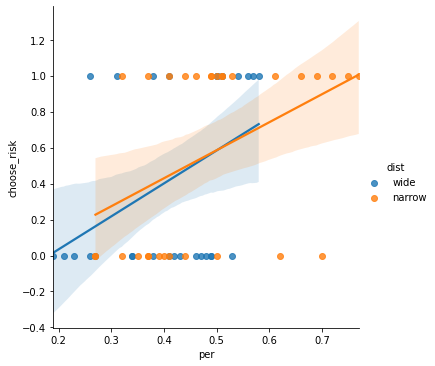

sub-5dd00a19b51b3e103a6f50c8


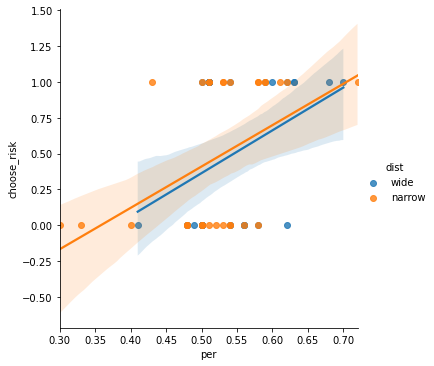

sub-5e45a700703c9408d2413f8d


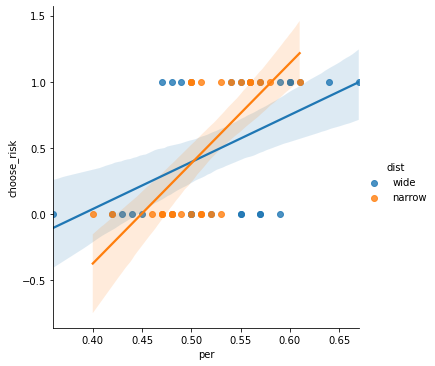

sub-5e850b0e390e520ec806b084


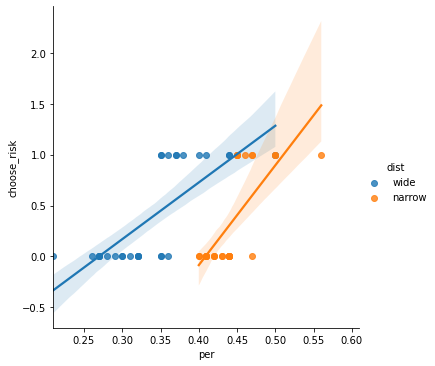

sub-60f6ce6de6cf393bcde0c14d


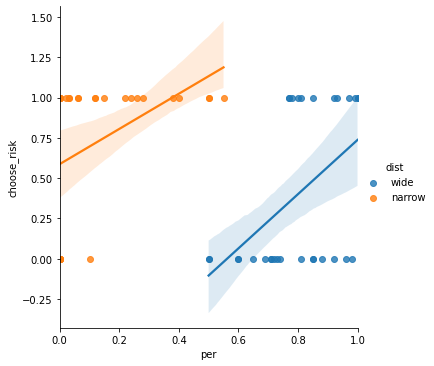

sub-60fd080d5476f4a77211bafb


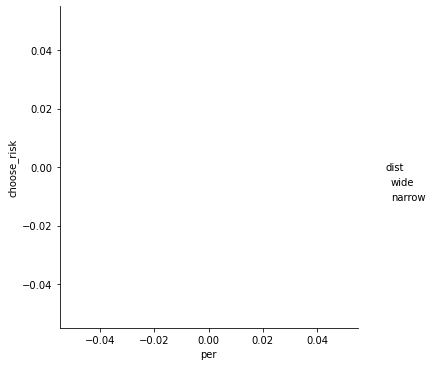

sub-63d4d6434407b2b392e65863


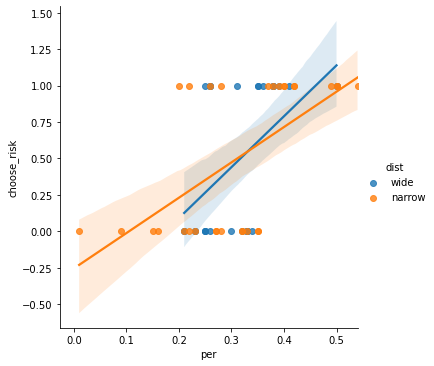

sub-5fc880e2e2e6de210e008e1b


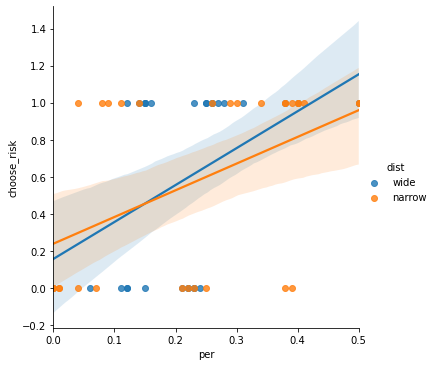

sub-6346c80dad82da684ce0a3df


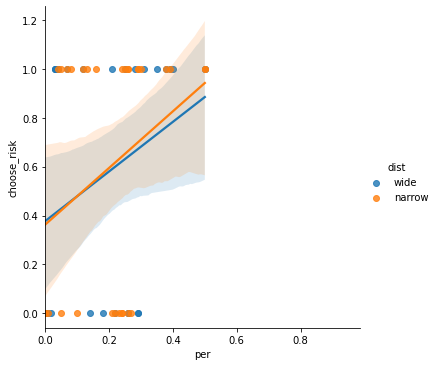

sub-5e13542bc12a3699bbdc8753


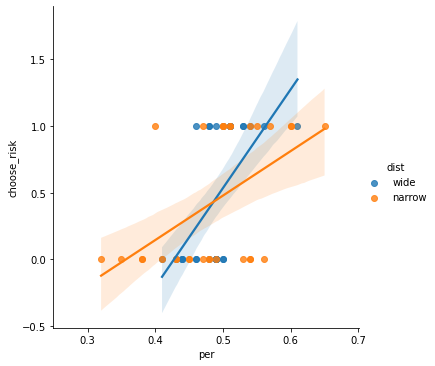

sub-5f6f28ca6df91347f156ad9a


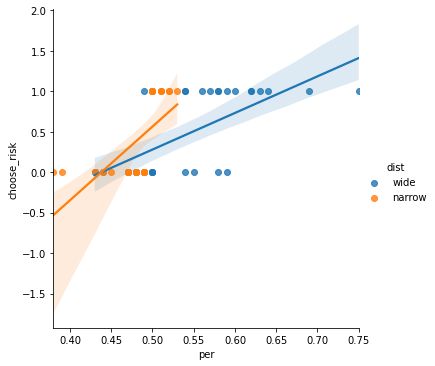

sub-5ed57ec8141d24118731f1bc


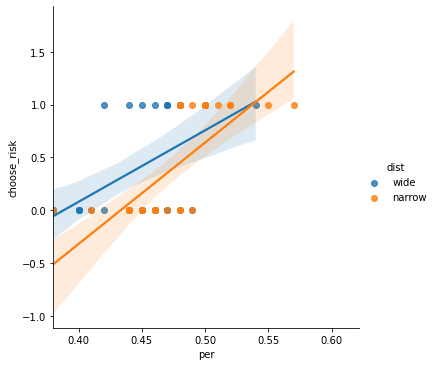

sub-628fb4c3880a08418cedd2d2


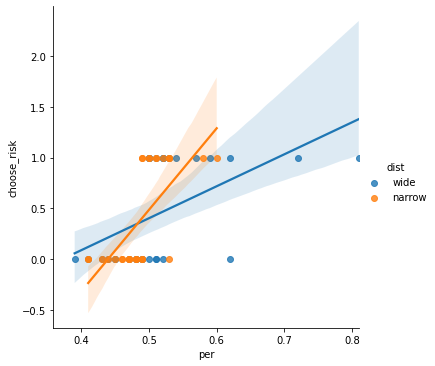

sub-5fea025ffeba314a5f1fbda8


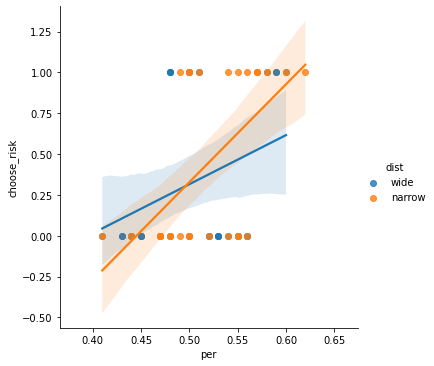

sub-614fca8245a450546842e487


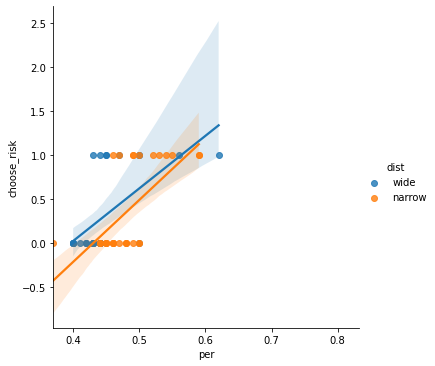

In [109]:
for sub in sub_df['sub'].unique():
    print(sub)
    plt_df=amb_df[amb_df['sub']==sub]
    plt_df[plt_df['dist'].isin(['narrow','wide'])]
    sns.lmplot(x='per',y='choose_risk',hue='dist',data=plt_df,hue_order=['wide','narrow'])
    plt.show()